# Анализ оттока клиентов банка

## Введение

Цель исследования - определить мероприятия, которые можно провести, чтобы вернуть ушедших клиентов и удержать тех, кто может уйти.

Основные задачи:
* сегментировать клиентов на компактные однородные сегменты;
* выделить сегменты клиентов, которые склонны уходить из банка;
* сформировать рекомендации для удержания клиентов и возврата ушедших.

## Используемые данные

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:
* userid — идентификатор пользователя,
* score — баллы кредитного скоринга,
* Исследовать типы данных и заменить их при необходимости;
* Закодировать категориальне переменные в столбце с городом и полом методом one-hot;
* city — город;
* gender — пол;
* age — возраст;
* equity — количество баллов собственности;
* balance — баланс на счёте;
* products — количество продуктов, которыми пользуется клиент;
* credit_сard — есть ли кредитная карта (0-нет, 1-да);
* last_activity — активный клиент (0-нет, 1-да);
* estimated_salary — заработная плата клиента;
* churn — имеет ли клиент по модели нашего банка высокую вероятность оттока или нет (0-нет, 1-да).

## Декомпозиция решения

1) Изучение общей информации: какие данные представлены, сколько их, и какая информация нам доступна.\
2) Подготовка данных:
* Исследовать типы данных и заменить их при необходимости;
* Закодировать категориальне переменные в столбце с городом и полом методом one-hot.
* Изучить названия столбцов и привести их к единому стилю;
* Исследовать пропуски: по возможности заменить пропуски, удалить или оставить как есть, в зависимости от типа пропуска:
** Изучить, как столбцы с пропусками коррелируют с имеющимися данными;
** MСAR - пропуски можно оставить или заполнить значениями, которые не навредят распределению значений столбца;
** MAR - можно заполнить средней/медианой для каждой группы, связанной с пропуском c учетом кол-ва пропусков;
** MNAR - без дополнительного обоснования заполнять или удалять пропуски нельзя, в таком случае пропуски придется оставить.
* Изучить данные на предмет явных и неявных дубликатов и удалить их, если допустимо.

3) Исследовательский анализ данных:
* Изучить распределение значений каждого столбца;
* Посмотреть показатели описательной статистики для столбцов;
* На основе среднего значения, медианы, моды посмотреть на типичного клиента в разрезе отточных клиентов и не отточных.
* Корреляционный анализ: 
** Посчитать и проанализировать корреляции данных всех столбцов со столбцом с признаком оттока с помощью коэффициента "phik";
** Графически отобразить корреляцию с помощью корреляционных матриц с цветовой шкалой для наглядного анализа;
** Выбрать те параметры, где оценка корреляции выше 10%.
* Исследование портретов уходящих клиентов: 
** Сравнить количественные портреты клиентов, т.е. показатели типичных клиентов. Взять подходящие средние тенденции и посчитать для каждой характеристики, на сколько процентов это число больше (меньше) у отточных по сравнению с неотточными. То, что будет менее 10% по модулю можно проверить стат.критерием для надёжности.
** Для выбранных непрерывных параметров, построить график плотности распределения вероятности для отточных и не отточных клиентов для определения диапазанов, где отток сильнее, чем по датасету в целом. 

4) Проверить гипотезы:
* Для непрерывных переменных использовать t-критерий Стьюдента или u-критерий Манна-Уитни. Обосновать выбор. Для теста пропорций использовать z-тест для пропорций. 
* Проверить гипотезу различия дохода между теми клиентами, которые готовы уйти и теми, которые остаются.
* Проверить гипотезу различия в средних баллах скоринга.
* Проверить гипотезу различия в среднем возрасте отточных и неотточныхе клиентов.

5) Промежуточный итог и сегментация:
* Собрать воедино результаты анализа и указать, какие признаки сильнее остальных влияют на отток клиетнов и какие значения или интервалы значений они принимают.
* Разделить клиентов по признакам отточности: размер групп от 300 до 2000 человек, доля отточности в группе хотябы в 1,3 раза выше, чем в среднем по датасету.

6) Выводы:
* Указать сегменты клиентов, которые склонны уходить чаще других.
* Сформировать рекомендации для возврата клиентов и удержания клиентов, склонных уйти.

# Изучим общую информацию о данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
! pip install missingno
import missingno as msno
! pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report
import numpy as np
import copy
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
import pylab 
import warnings
warnings.filterwarnings("ignore")

In [2]:
#ссылку распространять нельзя, после ревью ее удалю
data = pd.read_csv('bank_scrooge.csv')
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [4]:
print(f'В нашей таблице {data.shape[0]} строк и {data.shape[1]} столбцов.\
 Содежрится информация о {data.USERID.nunique()} клиентах из {data.city.nunique()} городов.')

В нашей таблице 10000 строк и 12 столбцов. Содежрится информация о 9927 клиентах из 3 городов.


Типы данных указаны корректно, названия столбцов надо немного подкорректировать. Пропуски есть в столбце с возрастом и величиной средств на счетах.

In [5]:
data.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


In [6]:
print(f'Согласно нашим данным {data.churn.mean():.2%} клиентов готовы уйти.')

Согласно нашим данным 18.20% клиентов готовы уйти.


In [7]:
print(f'Лишь {data.last_activity.mean():.2%} клиентов недавно совершали значимую активность.')

Лишь 52.35% клиентов недавно совершали значимую активность.


Посмотрим, какие города представлены.

In [8]:
data['city'].value_counts()

Ярославль    5888
Рыбинск      2695
Ростов       1417
Name: city, dtype: int64

Посмотрим, сколько продуктов бывает у наших клиентов.

In [9]:
data['products'].value_counts()

2    5126
1    3341
3    1039
4     474
5      19
0       1
Name: products, dtype: int64

In [10]:
print(f'В нашем датасете у клиентов бывает от {data.products.min()} до {data.products.max()} продуктов.')

В нашем датасете у клиентов бывает от 0 до 5 продуктов.


Есть один клиент и вовсе без продуктов. Посмотрим, кто это.

In [11]:
data[data['products']==0]

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


Пожилая женщина из города Рыбинск, которая давно не делала значимых операций. При этом она относится к категории отточных клиентов и у нас нет информации о размере ее активов. Можно удалить эту клиентку из нашего датасета.

In [12]:
data = data.drop([8957])

Посмотрим, какие баллы собственности бывают у наших клиентов.

In [13]:
data['equity'].value_counts()

0    2592
5    1918
4    1850
3    1542
2    1052
1     774
6     161
7      80
8      17
9      13
Name: equity, dtype: int64

In [14]:
print(f'В нашем датасете у клиентов бывает от {data.equity.min()} до {data.equity.max()} баллов собственности.')

В нашем датасете у клиентов бывает от 0 до 9 баллов собственности.


## Предобработка данных

### Изменим названия столбцов. Приведем к общему стилю.

In [15]:
data = data.rename(
    columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary'})

In [16]:
data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

### Исследуем дубликаты

Узнаем есть ли полные явные дубликаты.

In [17]:
data.duplicated().sum()

0

Явных дубликатов нет, посмотрим как часто у нас повторяются люди с одним идентификатором. 

In [18]:
data['user_id'].duplicated().sum()

73

In [19]:
print(f'В процентах от всего датасета их всего {data.user_id.duplicated().sum() / len(data):.2%} клиентов.')

В процентах от всего датасета их всего 0.73% клиентов.


Посмотрим как выглядят такие дубликаты, может будет за что зацепиться.

In [20]:
data[data['user_id'].duplicated()].head(7)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1583,190253,726.0,Ярославль,М,49.0,0,NaN,1,1,1,177700.78,0
1837,210662,896.0,Рыбинск,Ж,37.0,0,NaN,2,0,0,90916.04,0
2138,131419,739.0,Рыбинск,Ж,37.0,3,1307941.65,3,0,0,103867.47,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2302,220816,934.0,Рыбинск,Ж,74.0,5,1294285.39,3,1,0,95606.80,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
2998,208081,821.0,Рыбинск,Ж,62.0,3,493608.26,2,1,1,33491.45,0


Посмотрим, сколько отточных и неотточных клиентов среди дубликатов, а за одно как они распределены по городам.

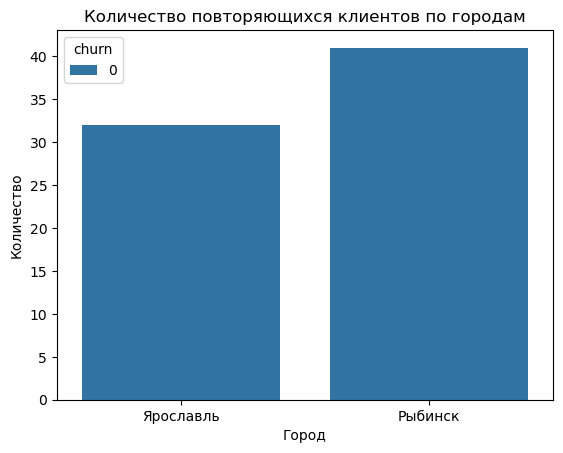

In [21]:
sns.countplot(data=data[data['user_id'].duplicated()], x='city', hue='churn')

plt.ylabel('Количество')

plt.xlabel('Город')

plt.title("Количество повторяющихся клиентов по городам")

plt.show()

Получаем, что дубликаты клиентов есть только в Ярославле и Рыбинске и только среди тех клиентов, кто не собирается покидать банк. Скорее всего, это как-то связано с выгрузкой информации о клиентах этих городов. Удалим такие дубликаты, так как их мало.

In [22]:
data = data.drop_duplicates(subset='user_id')

## Исследуем пропуски

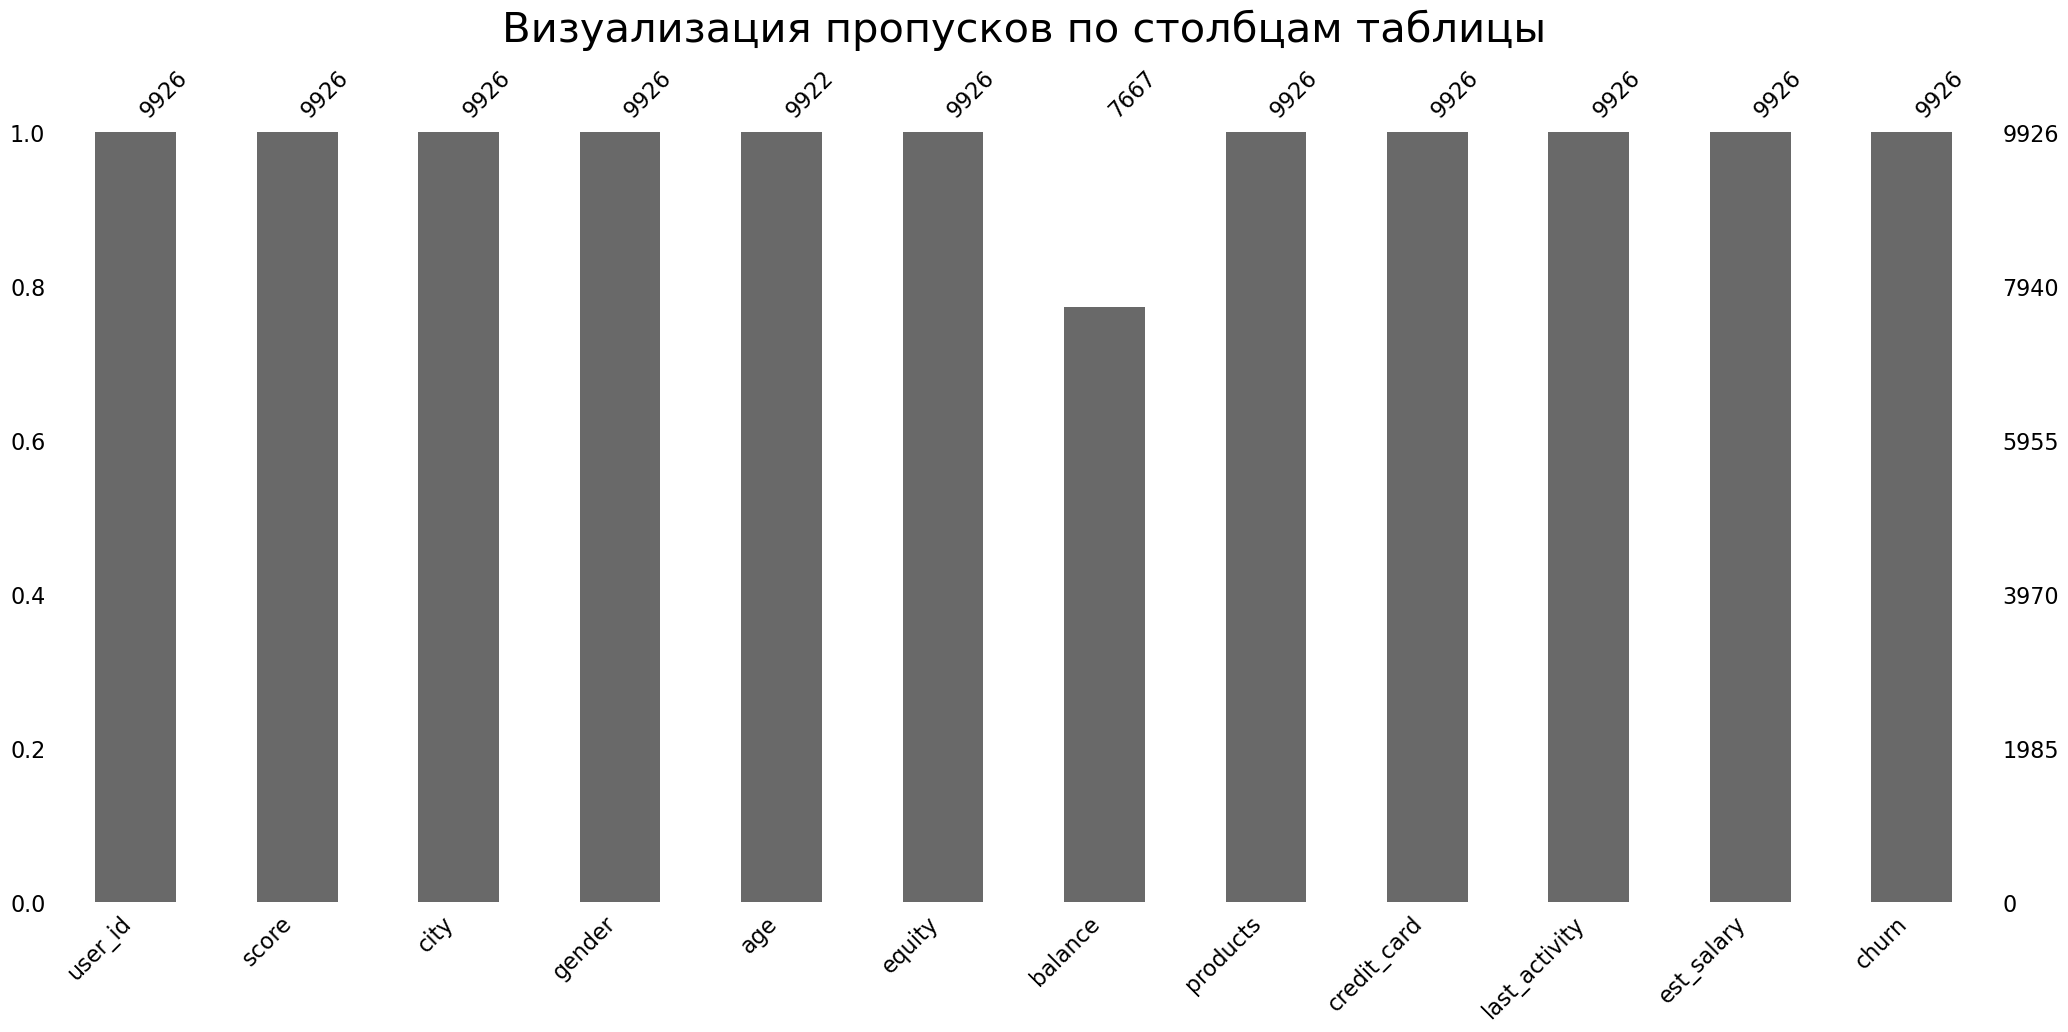

In [23]:
msno.bar(data)
plt.title("Визуализация пропусков по столбцам таблицы", pad=65, fontsize=30)
plt.show()

In [24]:
print(f'У нас имеется всего {data.user_id.count()-data.age.count()} пропуска в столбце с возрастом\
 и {data.user_id.count()-data.balance.count()} пропусков в столбце с балансом.')

У нас имеется всего 4 пропуска в столбце с возрастом и 2259 пропусков в столбце с балансом.


**Посмотрим сперва на клиентов с пропущенным возрастом.**

In [25]:
data[data['age'].isna()]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


Удалим их. Так как их крайне мало.

In [26]:
data=data.dropna(subset=['age'])

**Теперь приступаем к пропускам в балансе.**\
Сперва посмотрим, какую долю имеют данные спропусками в зависимости от разных категориальных признаков.\
Посмотрим на долю пропусков в зависимости от признака отточности.

In [27]:
def missing_count (groupby):
    missing_grouped = 0
    missing_grouped = data[data['balance'].isna()].groupby(groupby)['user_id'].count()
    missing_grouped = missing_grouped / data.groupby(groupby)['user_id'].count() * 100
    return round(missing_grouped,2)

In [28]:
missing_count('churn')

churn
0    27.73
1     0.66
Name: user_id, dtype: float64

Среди отточных клиентов всего 0,66% людей имеют пропуски в балансе. Среди тех клиентов, кто не уходит из банка больше четверти с пропусками. У пропусков в балансе есть связь, как минимум, со столбцом "churn".
Посмотрим, что с другими столбцами.

Посмотрим на зависимость от активных и неактивных клиентов.

In [29]:
missing_count('last_activity')

last_activity
0    21.53
1    23.90
Name: user_id, dtype: float64

У активных и неактивных клиентов примерно одинаковое число пропущенных значений в столбце с балансом. Скорее всего связи с пропусками нет.

Рассмотрим кредитные карты.

In [30]:
missing_count('credit_card')

credit_card
0    13.11
1    27.31
Name: user_id, dtype: float64

У клиентов с кредитной картой пропуски встречаются в 2 раза чаще, чем у остальных клиентов.

Посмотрим на пропуски по числу продуктов.

In [31]:
products_miss = missing_count('products').reset_index().rename(
    columns={'user_id': 'product_missing,%'})
#products_miss

In [32]:
prod_id_count = data['products'].value_counts().reset_index().rename(
    columns={'index': 'products', 'products': 'id_count'})
#prod_id_count

In [33]:
prod_id_count.merge(products_miss, on='products')

,products,id_count,"product_missing,%"
0,2,5095,6.08
1,1,3306,58.11
2,3,1028,2.72
3,4,474,NaN
4,5,19,NaN


Чем больше продуктов, тем меньше пропусков в балансе. Почти все пропуски у клиентов с 1 продуктом. При этом в банке клиентов с 2 продуктами даже больше, чем с 1. И также мы помним, что почти все эти клиенты не отточные. Возможно, это клиенты, которые не пользуются банковским счетом, а имеют какой-то другой 1 продукт, например, страхование или только брокерский счет.\
Надо такой вопрос задать составителям базы, возможно можно будет сделать ее более понятной.

In [34]:
data[data['balance']==0]['user_id'].count()

2

В данных всего 2 человека с пустыми счетами. Возможно, пропуски связаны с пустыми счетами. Обычно, банки при принятии клиента на обслуживание автоматически открывают счет. И даже если клиент им не пользуется, то у клиента имеется нулевой счет.

Посмотрим на связь пропусков с баллами собственности.

In [35]:
equity_balance_isna = missing_count('equity')

In [36]:
data['equity'].value_counts().reset_index().sort_values(by='index').rename(
    columns={'index': 'equity_score'}).join(equity_balance_isna, on='equity_score').set_index('equity_score')

,equity,user_id
equity_score,,
0,2554,83.99
1,771,14.79
2,1046,NaN
3,1531,NaN
4,1841,NaN
5,1909,NaN
6,161,NaN
7,79,NaN
8,17,NaN


Мы видим, что у клиентов, у которых меньше всего имущества больше всего доля пропусков в балансе. И одновременно это еще неотточные клиенты и у них чаще всего 1 продукт. Вполне возможно, что эти клиенты имеют пустые счета, то есть не пользуются ими или не имеют их вовсе в нашем банке.

Посмотрим как пропуски в балансе распределены по полу и городам.

In [37]:
missing_count('gender')

gender
Ж    20.11
М    25.41
Name: user_id, dtype: float64

In [38]:
missing_count('city')

city
Ростов       16.60
Рыбинск      21.68
Ярославль    24.75
Name: user_id, dtype: float64

По городам и полу доли пропусков распределены без больших перекосов.

В итоге, почти все пропуски приходятся на клиентов, которые не собираются уходить из банка. И в то же время подавляющее большинство пропусков у клиентов с 0 бллами собственности и 1 продуктом.\
Соответственно, у пропусков есть высокая связь со столбцом "churn", "equity" и "products".

**Посмотрим корреляционную матрицу, чтобы оценить связь столбца с балансом и связь пропусков в столбце с другими столбцами.**

Добавим новый столбец, где 0 означает отсутствие пропуска, а 1 - его наличие.

In [39]:
def miss_balance (balance):
    if balance >= 0:
        return 0
    else:
        return 1
    
data['missing_balance'] = data['balance'].apply(miss_balance)
#data['missing_balance'].head(20)

In [40]:
balance_phik = data.set_index("user_id")

In [41]:
interval_cols = ['score', 'age', 'balance', 'est_salary']
phik_overview = balance_phik.phik_matrix(interval_cols=interval_cols)

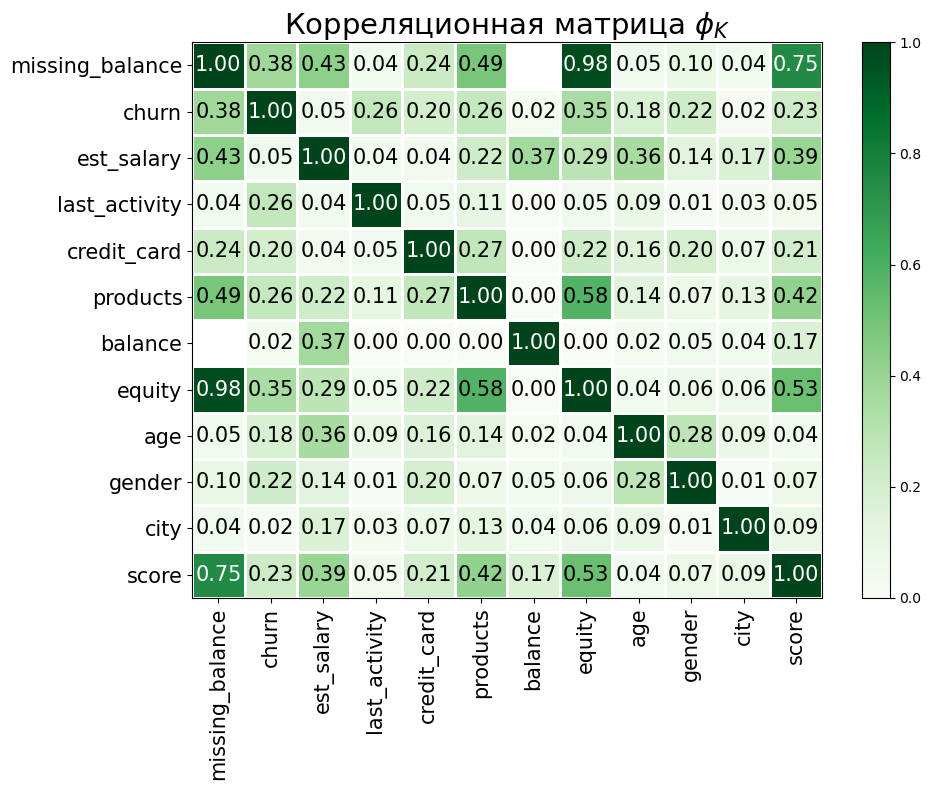

In [42]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляционная матрица $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

Как мы ранее заметили высокая связь у наличия и отсутствия пропусков есть со столбцами с признаком отток/не отток, с количеством продуктов и самая высокая связь с баллами собсвенности. Помимо этого высокая связь с баллами скоринга и зарплатой.

Посмотрим на то, как распределены значения зарплаты и скоринга в случае пропуска в балансе.\
Начнем с оценок скоринга.\
Можно еще заметить, что "score" из исходных данных коррелирует сильнее всех с количеством продуктов у клиента и баллами собственности. Как и пропуски в балансе. 

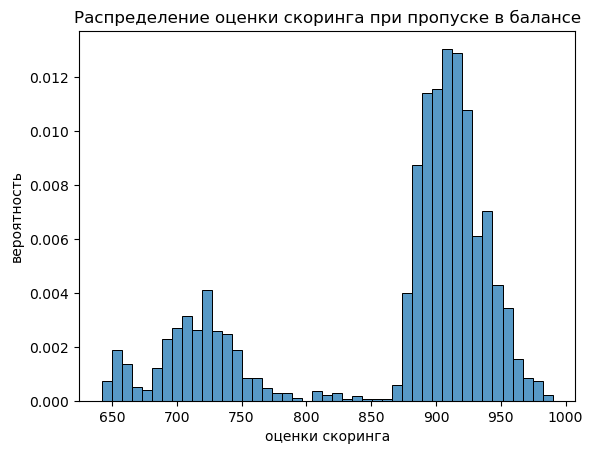

In [43]:
sns.histplot(data.loc[data['missing_balance']==1]['score'],stat='density')
plt.title('Распределение оценки скоринга при пропуске в балансе')
plt.ylabel('вероятность')
plt.xlabel('оценки скоринга')
plt.show()

Есть два пика. Первый около 730 баллов и второй около 910 баллов.

Посмотрим на распределение оценок скоринга, когда нет пропусков в балансе. 

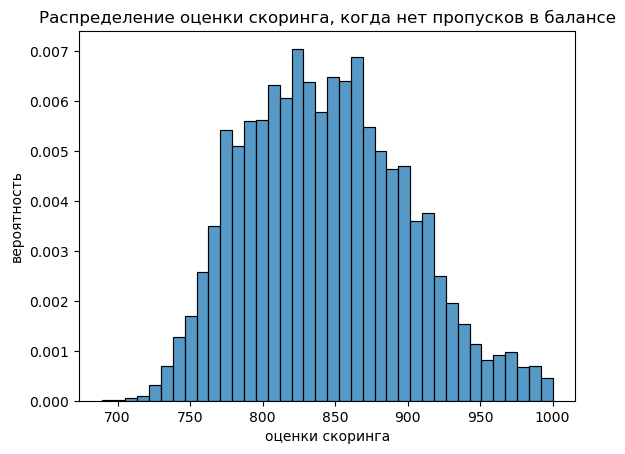

In [44]:
sns.histplot(data.loc[data['missing_balance']==0]['score'],stat='density')
plt.title('Распределение оценки скоринга, когда нет пропусков в балансе')
plt.ylabel('вероятность')
plt.xlabel('оценки скоринга')
plt.show()

У оценок скоринга без пропусков в балансе один пик в районе 820. Посчитаем медианы оценки скоринга, когда есть пропуски и когда их нет.

In [45]:
# когда нет пропусков
data.loc[data['missing_balance']==0]['score'].median()

841.0

In [46]:
# когда есть пропуски
data.loc[data['missing_balance']==1]['score'].median()

903.0

У клиентов с пропусками медиана выше. Что странно, ведь пропуски в основном у тех, у кого 0 баллов собственности и 1 продукт. Получается медиана их скоринга выше.\
Проделаем такое же исследование для зарплаты.

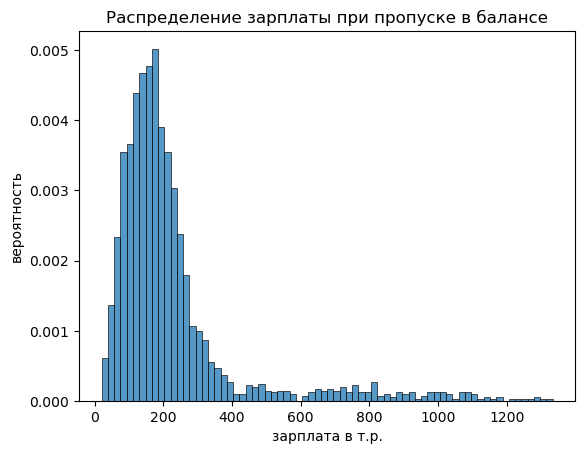

In [47]:
# зарплата для клиентов с пропусками в балансе
sns.histplot(data.loc[data['missing_balance']==1]["est_salary"]/1000,stat='density')
plt.title('Распределение зарплаты при пропуске в балансе')
plt.ylabel('вероятность')
plt.xlabel('зарплата в т.р.')
plt.show()

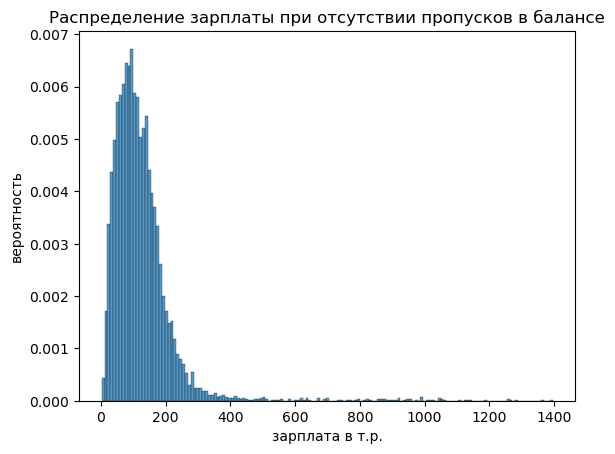

In [48]:
# зарплата для клиентов без пропусков в балансе
sns.histplot(data.loc[data['missing_balance']==0]["est_salary"]/1000,stat='density')
plt.title('Распределение зарплаты при отсутствии пропусков в балансе')
plt.ylabel('вероятность')
plt.xlabel('зарплата в т.р.')
plt.show()

На первый взгляд распределения похожи, но пик у графика с пропусками ближе к 200. Посчитаем медианы оценки скоринга, когда есть пропуски и когда их нет.

In [49]:
# медиана, когда нет пропусков, в тысячах рублей
(data.loc[data['missing_balance']==0]["est_salary"]/1000).median()

106.3552

In [50]:
# медиана, когда есть пропуски, в тысячах рублей
(data.loc[data['missing_balance']==1]["est_salary"]/1000).median()

174.76717000000002

Для клиентов с пропусками зарплата выше. Но из этой информации можно лишь сделать вывод, что пропуски у потенциально более состоятельных людей с более высокими баллами скоринга.

Более интерпретируемый и полезный вывод в том, что подавляющее большинство пропусков у клиентов с 0 бллами собственности и 1 продуктом. Можно эту информацию принести администраторам баз данных и посмотреть с ними почему это могло произойти.

**Посмотрим, можем ли мы как-то заполнить пропуски в балансе.**

Сильнее всего баланс коррелирует с зарплатой. Посмотрим как можно разбить на группы зарплату в зависимости от баланса.

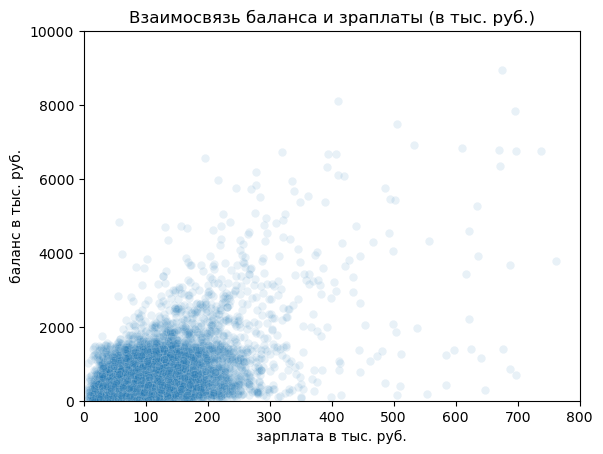

In [51]:
sns.scatterplot(x=data["est_salary"]/1000,
              y=data["balance"]/1000,
              data=data,
              alpha=0.10)
plt.xlim(0, 800)
plt.ylim(0, 10000)
plt.title('Взаимосвязь баланса и зраплаты (в тыс. руб.)')
plt.ylabel('баланс в тыс. руб.')
plt.xlabel('зарплата в тыс. руб.')
plt.show()

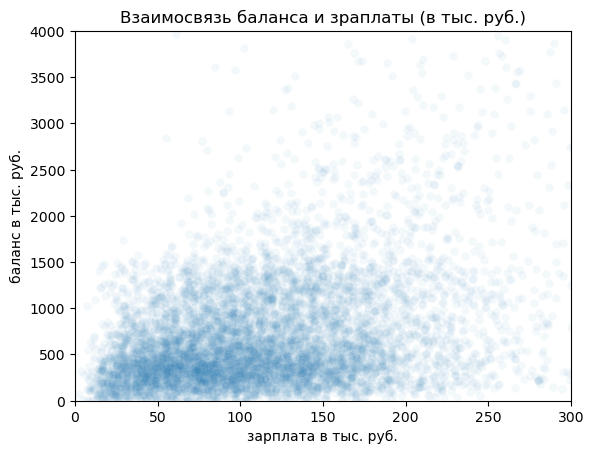

In [52]:
sns.scatterplot(x=data["est_salary"]/1000,
              y=data["balance"]/1000,
              data=data,
              alpha=0.05)
plt.xlim(0, 300)
plt.ylim(0, 4000)
plt.title('Взаимосвязь баланса и зраплаты (в тыс. руб.)')
plt.ylabel('баланс в тыс. руб.')
plt.xlabel('зарплата в тыс. руб.')
plt.show()

Наибольшая часть значений в прямоугольнике, где баланс до 1,5 млн. рублей, а зарплата до 200 тысяч рублей.\
Мы видим, что при росте зарплаты выше 100 тысяч рублей чаще начинают появляться значения с балансом выше 2 млн. рублей.\
А при росте зп выше 150 тысяч чаще начинают появляться значения баланса выше 3 лмн. рублей.\
Мы можем взять три группы: зп до 100 тысяч рублей, от 100 до 150, от 150 и выше.\
Посмотрим медианы баланса для таких зарплат.

In [53]:
data.query('est_salary<100000')['balance'].median()

417031.67

In [54]:
data.query('est_salary>=100000 and est_salary<150000')['balance'].median()

550172.74

In [55]:
data.query('est_salary>=150000')['balance'].median()

826470.915

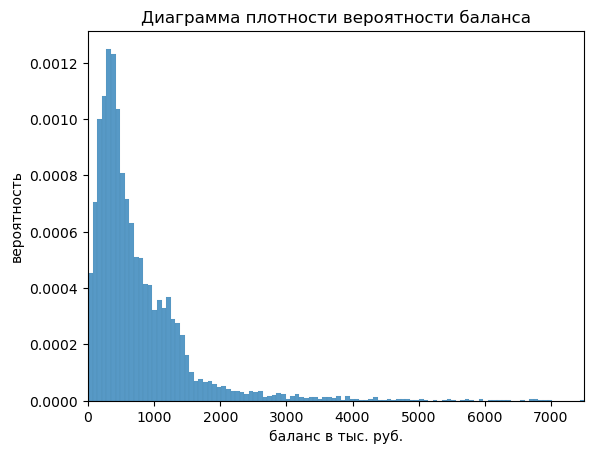

In [56]:
sns.histplot(data['balance']/1000,stat='density')
plt.xlim(0, 7500)
plt.title('Диаграмма плотности вероятности баланса')
plt.ylabel('вероятность')
plt.xlabel('баланс в тыс. руб.')
plt.show()

Распределение значений баланса сильно смещено вправо. Если мы заменим пропуски в балансе медианами по трем группам исходя из зарплаты, то очень сильно увеличим кол-во значениий баланса до 1 млн. рублей.\
Пропусков примерно четверть от всего датасета, поэтому оставим пропуски и трогать их не будем. Тем более, что они скорее всего связаны с теми клиентами, которые по каким-то причинам не имеют банковского счета или имеют там нулевые остатки.\
Самое важное, что это не отточные клиенты. Когда мы будет составлять портреты наиболее отточных клиентов, то эти пропуски нам не помешают.

## Закодируем переменные в столбце с городом и полом

**Начнем с города.**\
У нас есть 3 города. Мы создадим для каждого города отдельный столбец. Если строка соответствует данному городу, то будет стоять 1, т.е. True.\
Аналогично для пола. Используем метод pandas.get_dummies().

In [57]:
data_initial = copy.deepcopy(data)
data = pd.get_dummies(data)

In [58]:
data = data.rename(columns={'city_Ростов': 'rostov', 'city_Рыбинск': 'rybinsk', 'city_Ярославль': 'yaroslavl', 
                     'gender_Ж': 'female', 'gender_М':'male'})
data.head()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missing_balance,rostov,rybinsk,yaroslavl,female,male
0,183012,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,0,1,0,1,0
1,146556,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,0,1,0,1,0
2,120722,892.0,30.0,0,NaN,1,1,1,107683.34,0,1,0,1,0,1,0
3,225363,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,0,1,1,0
4,157978,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,0,1,0,1


# Исследовательский анализ данных

## Изучим распредления дискретных и непрерывных переменных

Для удобства создадим дополнительные столбцы, с оценкой баланса и зарплатой в тысячах рублей.

In [59]:
data['est_salary_th'] = data['est_salary']/1000
data['balance_th'] = data['balance']/1000

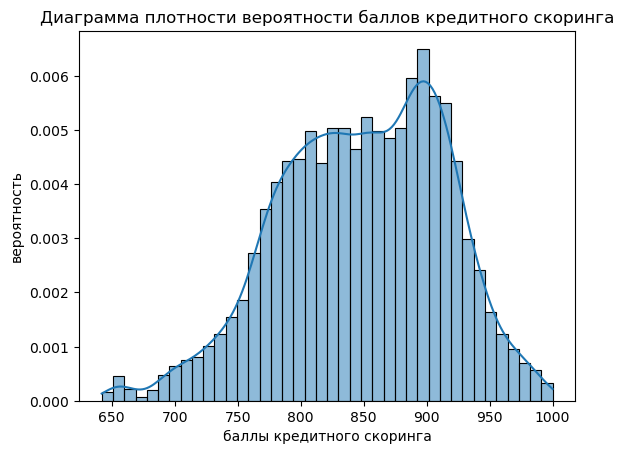

In [60]:
sns.histplot(data['score'],stat='density', kde=True)
plt.title('Диаграмма плотности вероятности баллов кредитного скоринга')
plt.ylabel('вероятность')
plt.xlabel('баллы кредитного скоринга')
plt.show()

Распределение скошено влево, но без особо длинных хвостов. Основная часть клиентов имеют баллы от 800 и более. В целом, банк высоко оценивать кредитоспособность клиентов.

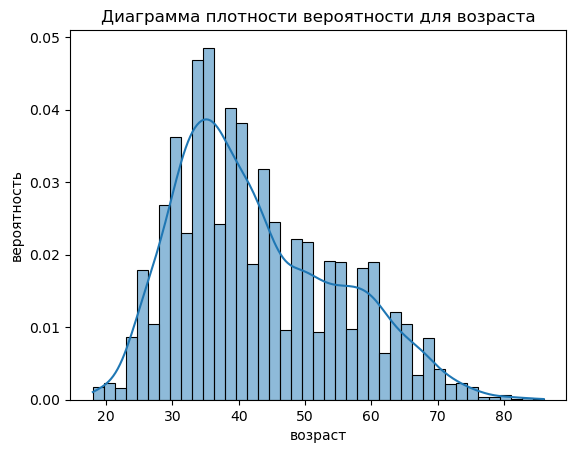

In [61]:
sns.histplot(data['age'],stat='density', kde=True)
plt.title('Диаграмма плотности вероятности для возраста')
plt.ylabel('вероятность')
plt.xlabel('возраст')
plt.show()

Распределение скошено вправо, но без особо длинных хвостов. Банк сконцентрирован на клиентах от 30 до 50 лет. 

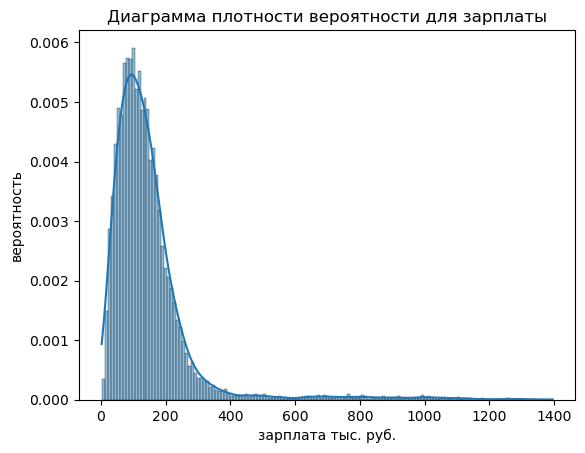

In [62]:
sns.histplot(data['est_salary_th'],stat='density', kde=True)
plt.title('Диаграмма плотности вероятности для зарплаты')
plt.ylabel('вероятность')
plt.xlabel('зарплата тыс. руб.')
plt.show()

Очень сильный хвост справа. Вплоть до почти 1,5 млн. рублей. Но зарплаты выше 400 тысяч рублей встречаются уже редко.

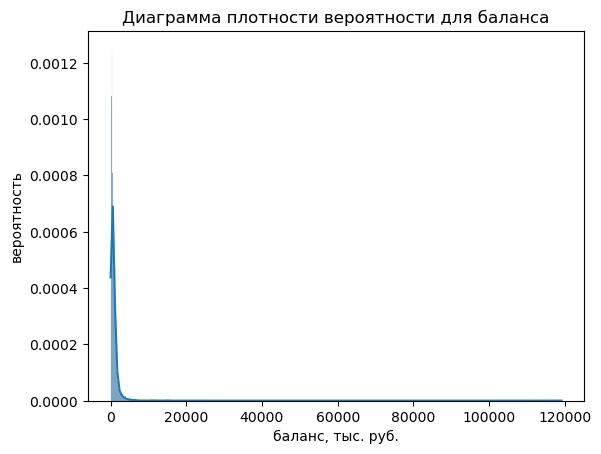

In [63]:
sns.histplot(data['balance_th'],stat='density', kde=True)
plt.title('Диаграмма плотности вероятности для баланса')
plt.ylabel('вероятность')
plt.xlabel('баланс, тыс. руб.')
plt.show()

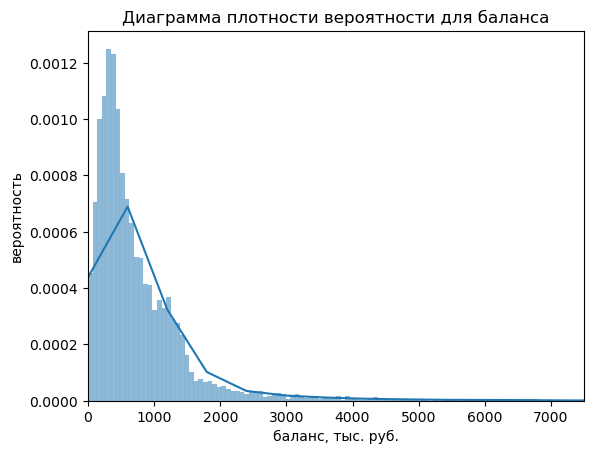

In [64]:
sns.histplot(data['balance_th'],stat='density', kde=True)
plt.title('Диаграмма плотности вероятности для баланса')
plt.ylabel('вероятность')
plt.xlabel('баланс, тыс. руб.')
plt.xlim(0, 7500)
plt.show()

Тоже имеем очень длинный хвост. Вплоть до 120 млн. рублей. Но основная масса клиентов имеет баланс до 3 млн. рублей.

## Типичный клиент

Посмотрим как можно охарактеризовать обычного клиента нашего банка. Для удобства создадим дополнительные столбцы, с оценкой баланса и зарплатой в тысячах рублей.

In [65]:
description_table = data[["score", "age", "equity", "products", "credit_card", "last_activity", "churn",
      "rostov", "yaroslavl", "rybinsk", "female", "male", "est_salary_th", "balance_th"]].describe()
description_table

,score,age,equity,products,credit_card,last_activity,churn,rostov,yaroslavl,rybinsk,female,male,est_salary_th,balance_th
count,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,7663.000000
mean,848.720923,42.725559,2.634247,1.871699,0.680105,0.523382,0.183229,0.142713,0.590002,0.267285,0.499093,0.500907,147.898874,828.248160
std,65.393520,12.172175,1.979425,0.792928,0.466459,0.499478,0.386874,0.349798,0.491858,0.442565,0.500024,0.500024,139.365465,1984.247693
min,642.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.546300,0.000000
25%,802.000000,33.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.254045,295.498985
50%,853.000000,40.000000,3.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,119.735430,524.961220
75%,900.000000,51.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,174.679638,980.801490
max,1000.000000,86.000000,9.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1395.064450,119113.552010


Изучив данную таблицу мы видим, что нереалистичной информации в данных нет. Больше всего разброс данных в столбце с зарплатой и балансом. Но и там реальные цифры. Поэтому обрезать данные не будем и диаграмму размаха смотреть нет смысла.\
Для изучения типичных значений для категориальных признаков будем брать моду, для зарплаты и баланса медиану, для дискретных - среднюю.

Для категориальных переменных посмотрим моду.

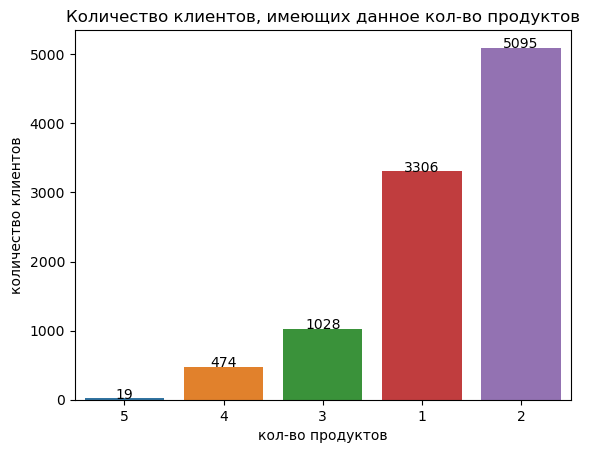

In [66]:
order = data.groupby('products')['user_id'].count().reset_index().sort_values(by='user_id')

ax = sns.countplot(x=data['products'], order=order['products'])

plt.ylabel('количество клиентов')

plt.xlabel('кол-во продуктов')

plt.title("Количество клиентов, имеющих данное кол-во продуктов")

for p in ax.patches:
 height = p.get_height() 
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+0.05, 
 s = '{:.0f}'.format(height), 
 ha = 'center') 
plt.show()

Соответственно, наиболее популярное среди клиентов число продуктов - 2. Это мода. Помимо этого часто встречается клиент с 1 продуктом.

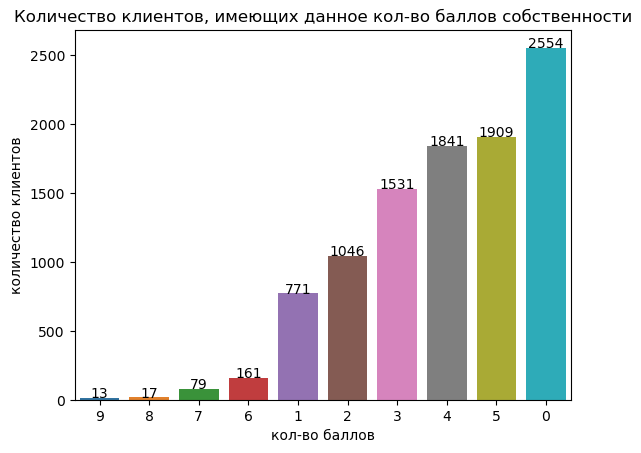

In [67]:
order = data.groupby('equity')['user_id'].count().reset_index().sort_values(by='user_id')

ax = sns.countplot(x=data['equity'], order=order['equity'])

plt.ylabel('количество клиентов')

plt.xlabel('кол-во баллов')

plt.title("Количество клиентов, имеющих данное кол-во баллов собственности")

for p in ax.patches:
 height = p.get_height() 
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+0.05, 
 s = '{:.0f}'.format(height),
 ha = 'center') 

plt.show()

Чаще всего у клиентов 0 баллов. Затем почти с одинаковой частотой идут 5,4,3 балла.

In [68]:
np.sort(data['last_activity'].unique())[:]

array([0, 1], dtype=int64)

In [69]:
def bar_chart(x_data):
    ax = sns.countplot(x=data[x_data])
    plt.ylabel('количество клиентов')
    plt.xlabel('значения столбца')
    labels = ['отсутствие', 'наличие']
    plt.xticks(np.sort(data['last_activity'].unique()), labels)

    for p in ax.patches:
        height = p.get_height() 
        ax.text(x = p.get_x()+(p.get_width()/2), 
        y = height+0.05, 
        s = '{:.0f}'.format(height),
        ha = 'center')

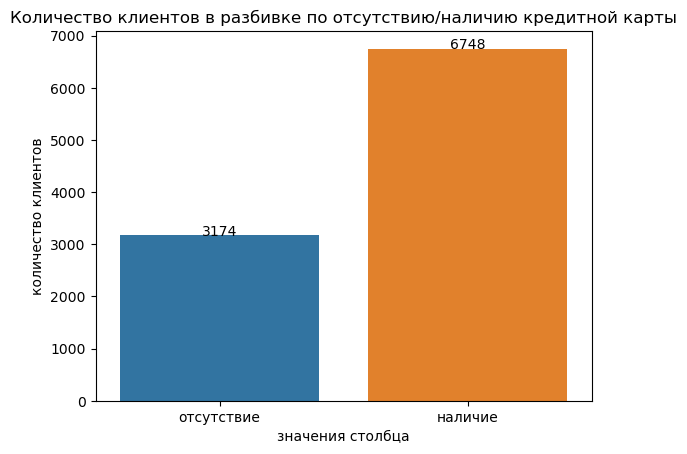

In [70]:
bar_chart('credit_card')

plt.title("Количество клиентов в разбивке по отсутствию/наличию кредитной карты")

plt.show()

У подавляющего большинства клиентов есть кредитная карта.

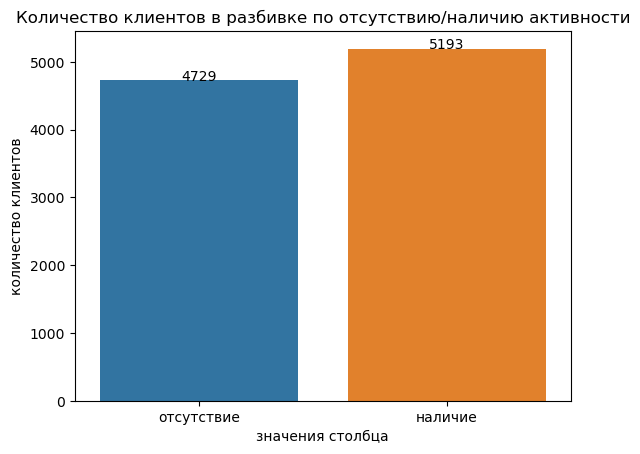

In [71]:
bar_chart('last_activity')

plt.title("Количество клиентов в разбивке по отсутствию/наличию активности")

plt.show()

Примерно поровну распределено количество людей у которых недавно была и не было значимой активности.

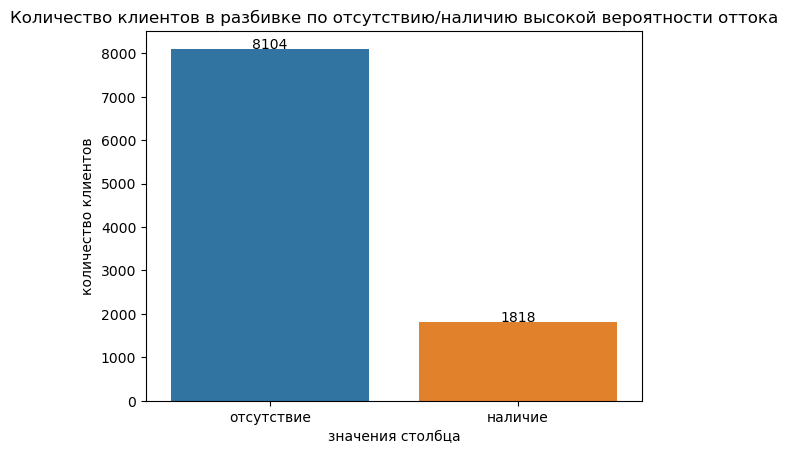

In [72]:
bar_chart('churn')

plt.title("Количество клиентов в разбивке по отсутствию/наличию высокой вероятности оттока")

plt.show()

In [73]:
print(f'Согласно нашим данным {data.churn.mean():.2%} клиентов готовы уйти.')

Согласно нашим данным 18.32% клиентов готовы уйти.


Теперь посмотрим на города и пол.

In [74]:
columnar_city = data.melt(value_vars=['rostov', 'rybinsk', 'yaroslavl']) 
#columnar_city.head()

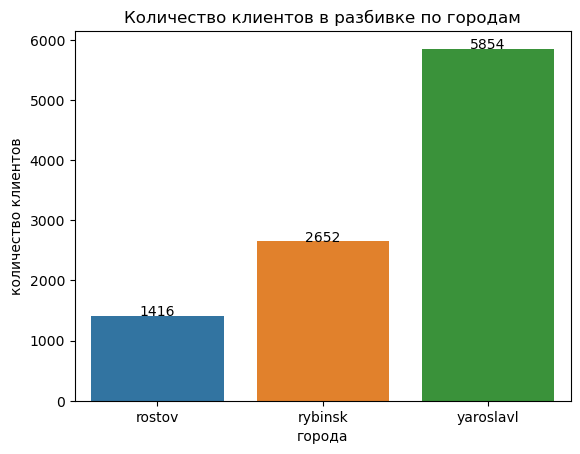

In [75]:
columnar_city = columnar_city.groupby('variable')['value'].sum().reset_index().sort_values(by='value')

ax = sns.barplot(x='variable', y='value', data=columnar_city)

plt.ylabel('количество клиентов')

plt.xlabel('города')

plt.title("Количество клиентов в разбивке по городам")

for p in ax.patches:
 height = p.get_height() 
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+0.05, 
 s = '{:.0f}'.format(height),
 ha = 'center') 

plt.show()

Основная часть клиентов из Ярославля. Больше половины всех клиентов. Из Ростова меньше всех.

In [76]:
columnar_gender = data.melt(value_vars=['female', 'male'])
#columnar_gender.head()

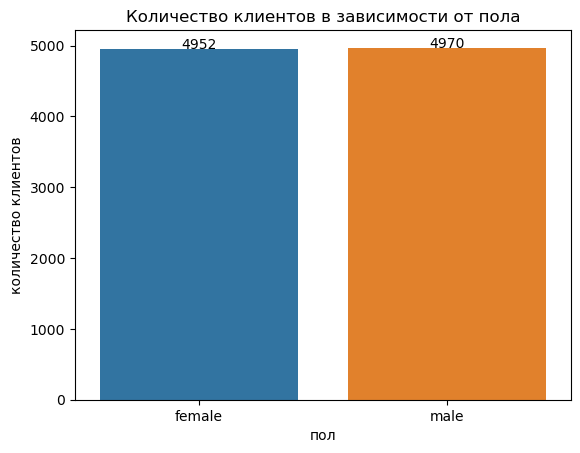

In [77]:
columnar_gender = columnar_gender.groupby('variable')['value'].sum().reset_index().sort_values(by='value')

ax = sns.barplot(x='variable', y='value', data=columnar_gender)

plt.ylabel('количество клиентов')

plt.xlabel('пол')

plt.title("Количество клиентов в зависимости от пола")

for p in ax.patches:
 height = p.get_height() 
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+0.05, 
 s = '{:.0f}'.format(height),
 ha = 'center') 

plt.show()

Примерно поровну женщин и мужчин.

**Итог по подразделу. Можно составить портрет типичного клиента нашего банка.**

In [78]:
print(f'Типичный клиент нашего банка проживает в Ярославле, имеет возраст {round(description_table.age[1],2)} года,\
 доход {round(description_table.est_salary_th[5],2)} тысяч в месяц,\
 баланс на счете {round(description_table.balance_th[5],2)} тысяч рублей.')

Типичный клиент нашего банка проживает в Ярославле, имеет возраст 42.73 года, доход 119.74 тысяч в месяц, баланс на счете 524.96 тысяч рублей.


In [79]:
print("С одинаковой вероятностью это может быть как мужчина, так и женщина.\
 Обычно клиент имеет два банковских продукта и 0 баллов собственности, владеет кредитной картой.")

С одинаковой вероятностью это может быть как мужчина, так и женщина. Обычно клиент имеет два банковских продукта и 0 баллов собственности, владеет кредитной картой.


In [80]:
typical_client=pd.DataFrame(
{"показатель":["возраст", "пол", "город", "зп,т.р.", 
              "баланс,т.р.", "продукты", "собственность", "отток/не отток", "кредитная карта", "активность"],
 "значение":[42.73, "M/Ж", "Ярославль", 119.74, 524.96, 2, 0, "не отток", "есть", "есть"]})

Все это можно вывести в качестве общей итоговой таблицы.

In [81]:
typical_client

,показатель,значение
0,возраст,42.73
1,пол,M/Ж
2,город,Ярославль
3,"зп,т.р.",119.74
4,"баланс,т.р.",524.96
5,продукты,2
6,собственность,0
7,отток/не отток,не отток
8,кредитная карта,есть
9,активность,есть


## Изучим типичного уходящего клиента

Посмотрим на типичного уходящего клиента в сравнении с не уходящем.

In [82]:
description_table_1_churn = (data.loc[data['churn']==1][["score", "age", "equity", "products", 
                            "credit_card", "last_activity", "churn", "rostov", "yaroslavl", 
                            "rybinsk", "female", "male", "est_salary_th", "balance_th"]].describe())
description_table_1_churn

,score,age,equity,products,credit_card,last_activity,churn,rostov,yaroslavl,rybinsk,female,male,est_salary_th,balance_th
count,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.0,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1806.000000
mean,863.361936,41.429593,3.763476,2.377338,0.551705,0.702420,1.0,0.145765,0.614411,0.239824,0.349285,0.650715,148.357483,1134.458209
std,49.580696,11.144754,1.586316,0.922162,0.497456,0.457319,0.0,0.352967,0.486868,0.427093,0.476875,0.476875,122.931982,2034.445549
min,706.000000,18.000000,0.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,10.880270,0.006000
25%,828.000000,32.000000,3.000000,2.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,83.285660,387.482165
50%,866.000000,39.000000,4.000000,2.000000,1.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,125.408880,783.908900
75%,898.000000,52.000000,5.000000,3.000000,1.000000,1.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,176.017838,1348.127553
max,1000.000000,75.000000,9.000000,5.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1263.028490,64866.210150


In [83]:
description_table_0_churn = (data.loc[data['churn']==0][["score", "age", "equity", "products", 
                            "credit_card", "last_activity", "churn", "rostov", "yaroslavl", 
                            "rybinsk", "female", "male", "est_salary_th", "balance_th"]].describe())
description_table_0_churn

,score,age,equity,products,credit_card,last_activity,churn,rostov,yaroslavl,rybinsk,female,male,est_salary_th,balance_th
count,8104.000000,8104.000000,8104.000000,8104.000000,8104.000000,8104.000000,8104.0,8104.000000,8104.000000,8104.000000,8104.00000,8104.00000,8104.000000,5857.000000
mean,845.436451,43.016288,2.380923,1.758268,0.708909,0.483218,0.0,0.142029,0.584526,0.273445,0.53270,0.46730,147.795992,733.828602
std,68.012034,12.372982,1.970443,0.713358,0.454293,0.499749,0.0,0.349101,0.492834,0.445755,0.49896,0.49896,142.799302,1959.055429
min,642.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,2.546300,0.000000
25%,796.000000,34.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,73.487070,279.004830
50%,848.000000,40.000000,3.000000,2.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.00000,0.00000,118.248515,475.354800
75%,900.000000,51.000000,4.000000,2.000000,1.000000,1.000000,0.0,0.000000,1.000000,1.000000,1.00000,1.00000,174.106043,853.826360
max,1000.000000,86.000000,9.000000,5.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.00000,1.00000,1395.064450,119113.552010


Визуализируем различия для категориальных переменных.\
Добавим для удобства столбец, который будет словами обозначать уходящих и не уходящих клиентов.

In [84]:
def churn_str (churn):
    if churn == 0:
        return 'не уходящие'
    else:
        return 'уходящие'

In [85]:
data['churn_str'] = data['churn'].apply(churn_str)
#data['churn_str'].head()

**Начнем с количества продуктов**.

In [86]:
def churn_groups (data, column):
    churn_groups = data.groupby(['churn_str',column])['user_id'].count().reset_index()
    churn_groups['sum'] = 0 
    
    #считаем сумму по всем не уходящим и уходящим клиентам и кладем ее в столбец sum
    churn_groups.loc[churn_groups['churn_str']=='не уходящие','sum']= \
    churn_groups[churn_groups['churn_str']=='не уходящие']['user_id'].sum()
    churn_groups.loc[churn_groups['churn_str']=='уходящие','sum']= \
    churn_groups[churn_groups['churn_str']=='уходящие']['user_id'].sum()
    
    #считаем долю каждой группы в общем количестве уходящих и не уходящих
    churn_groups['ratio']=round(churn_groups['user_id']/churn_groups['sum']*100,2)
    return churn_groups, churn_groups.loc[churn_groups['churn_str']=='уходящие']

In [87]:
products_churn, products_churn_1 = churn_groups(data, 'products')
#products_churn

In [88]:
def churn_bar (data, x_axis, y_axis):
    ax = sns.barplot(
    data=data, x=x_axis, 
    y=y_axis, hue='churn_str')

    for p in ax.patches:
        height = p.get_height() 
        ax.text(x = p.get_x()+(p.get_width()/2), 
        y = height+0.05, 
        s = '{:.1f}'.format(height), 
        ha = 'center') 
    return ax

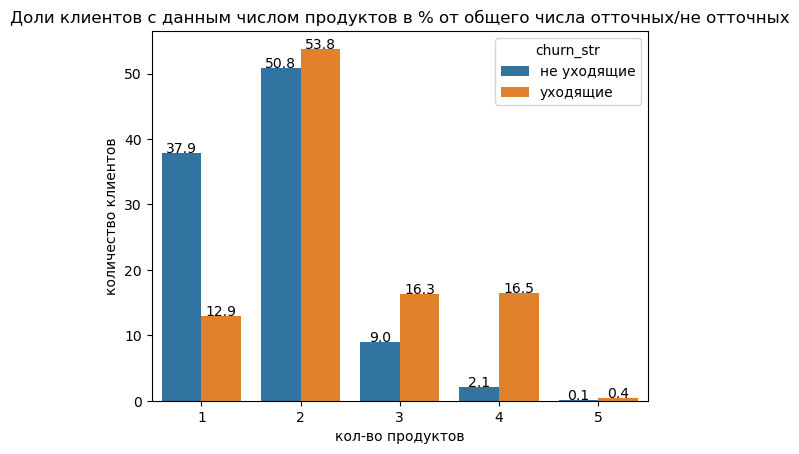

In [89]:
churn_bar(products_churn, products_churn['products'], products_churn['ratio'])
plt.ylabel('количество клиентов')
plt.xlabel('кол-во продуктов')
plt.title("Доли клиентов с данным числом продуктов в % от общего числа отточных/не отточных")
plt.show()

Получаем, что есть различия среди отточных и не отточных клиентов. В обоих группах чаще попадаются клиенты с 2 продуктами.\
Доля неотточных с 1 продуктом 38%, а среди отточных 13%. Доли клиентов 3 и 4 продуктами среди отточных по 16%. Среди неотточных таких мало - 9% и 2% соответственно.\
Потенциально, клиенты с 3 и 4 продуктами - слабое звено. Возможно, наш банк пока не так удобен для тех, кто активно использует банковские продукты.

**Посмотрим на баллы собственности.**

In [90]:
equity_churn, equity_churn_1 = churn_groups(data, 'equity')

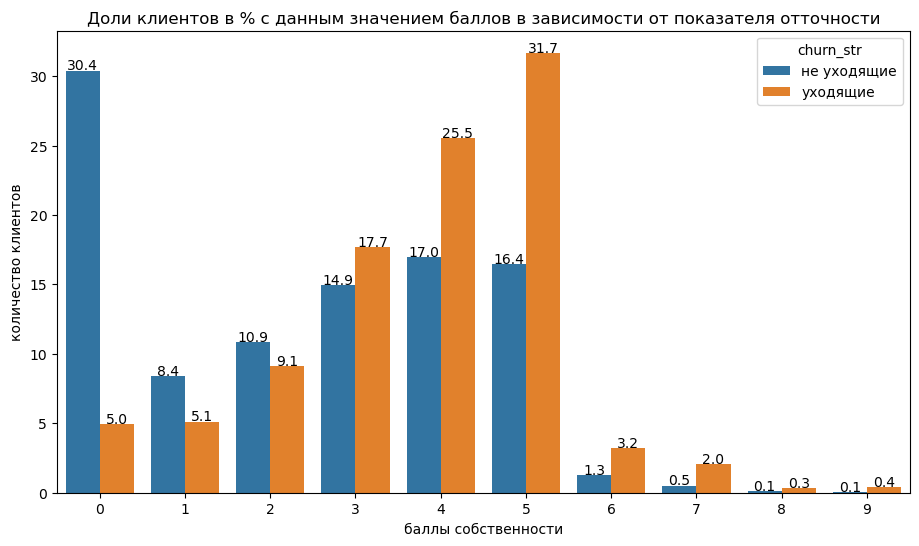

In [91]:
plt.figure(figsize=(11,6))
churn_bar(equity_churn, equity_churn['equity'], equity_churn['ratio'])
plt.ylabel('количество клиентов')
plt.xlabel('баллы собственности')
plt.title("Доли клиентов в % с данным значением баллов в зависимости от показателя отточности")
plt.show()

По баллам собственности тоже различия имеются. У клиентов, которые уходят чаще всего балы собственности 3,4,5. В то время как не уходящие клиенты в 30% случаев, т.е. чаще всего, имеют 0 баллов собственности.\
Значит более состоятельные люди уходят чаще.\
Среди не уходящих клиентов доля людей с тремя и более продуктами меньше, чем среди отточных.

**Кредитная карта.**

In [92]:
credit_churn, credit_churn_1 = churn_groups(data, 'credit_card')
#credit_churn

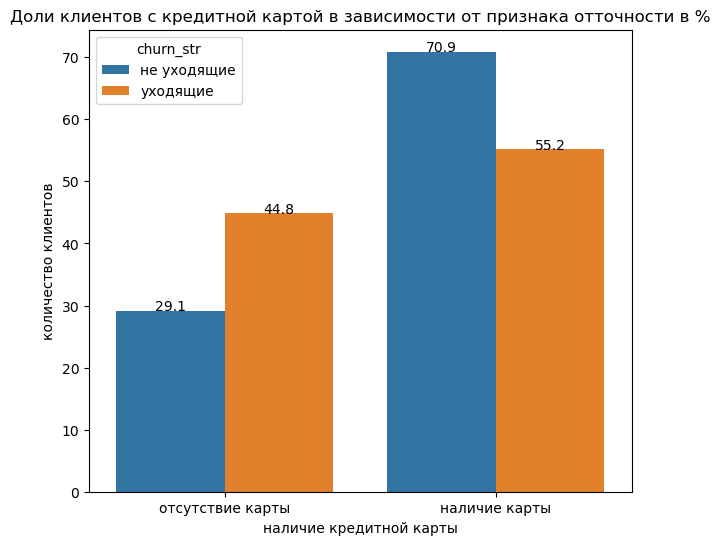

In [93]:
credit_churn # = credit_churn[credit_churn['credit_card']==1]

plt.figure(figsize=(7, 6))
churn_bar(credit_churn, credit_churn['credit_card'], credit_churn['ratio'])
plt.ylabel('количество клиентов')
plt.xlabel('наличие кредитной карты')
plt.title("Доли клиентов с кредитной картой в зависимости от признака отточности в %")
labels = ['отсутствие карты','наличие карты']
plt.xticks([0,1], labels)
plt.show()

Среди уходящих клиентов доля использующих кредитную карту более 55%. 
Среди не уходящих доля более 70%.\
Соответственно, отсутствует кредитная карта примерно у 45% уходящих и почти 30% не уходящих.

**Значимая активность.**

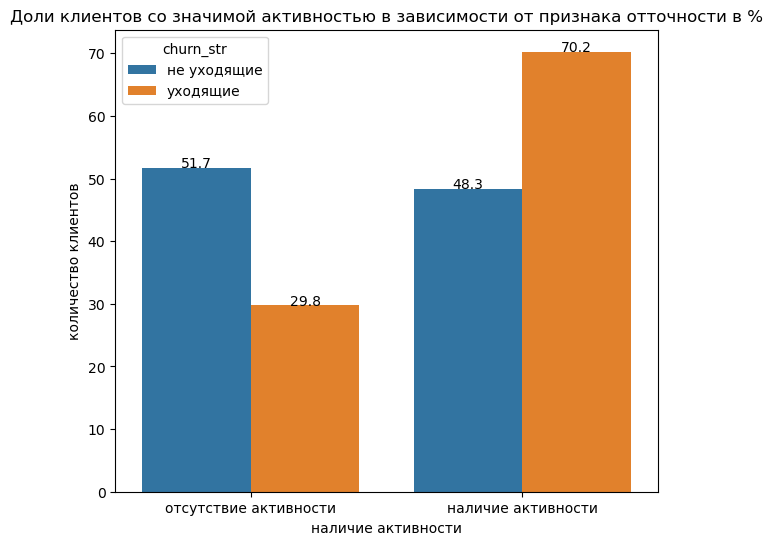

In [94]:
activity_churn, activity_churn_1 = churn_groups(data, 'last_activity')
activity_churn = activity_churn #[activity_churn['last_activity']==1]

plt.figure(figsize=(7, 6))
churn_bar(activity_churn, activity_churn['last_activity'], activity_churn['ratio'])
plt.ylabel('количество клиентов')
plt.xlabel('наличие активности')
plt.title("Доли клиентов со значимой активностью в зависимости от признака отточности в %")
labels = ['отсутствие активности','наличие активности']
plt.xticks([0,1], labels)
plt.show()

Среди тех клиентов, кто уходит значительно больше доля людей с активностью. Но это может также означать активность в связи с закрытием продуктов, счетов, выводы денег.\
У клиентов, которые не уходят доли людей с активностью и без примерно равны.

**Теперь посмотрим доли отточных клиентов в зависимости от пола**.

Добавим в сходные данные столбец с обозначением уходящего и не уходщяего клиента словами.

In [95]:
data_initial['churn_str'] = data_initial['churn'].apply(churn_str)
#data_initial.head()

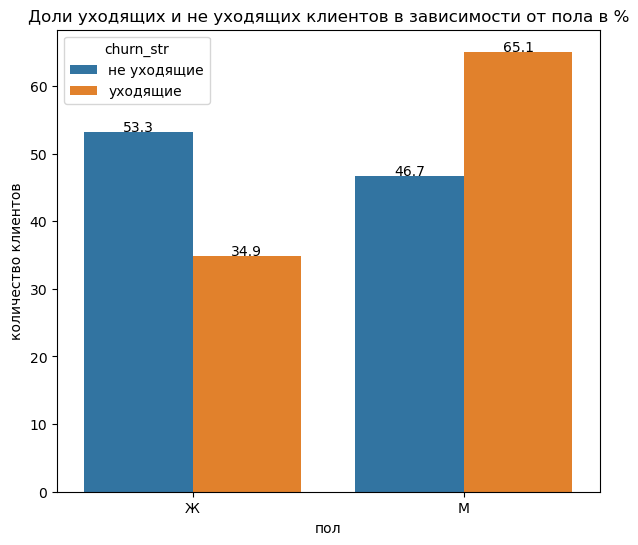

In [96]:
gender_churn, gender_churn_1 = churn_groups(data_initial, 'gender')

plt.figure(figsize=(7, 6))
churn_bar(gender_churn, gender_churn['gender'], gender_churn['ratio'])
plt.ylabel('количество клиентов')
plt.xlabel('пол')
plt.title("Доли уходящих и не уходящих клиентов в зависимости от пола в %")
#plt.legend([],[], frameon=False)
plt.show()

Получается, что среди не уходящи клиентов женщин 53.3, а мужчин 46.7. Среди уходящих уже мужчин 65.1, а женщин 34.9.

Получается, что среди мужчин желающих уйти значительно больше. 

**Посмотрим на города.**

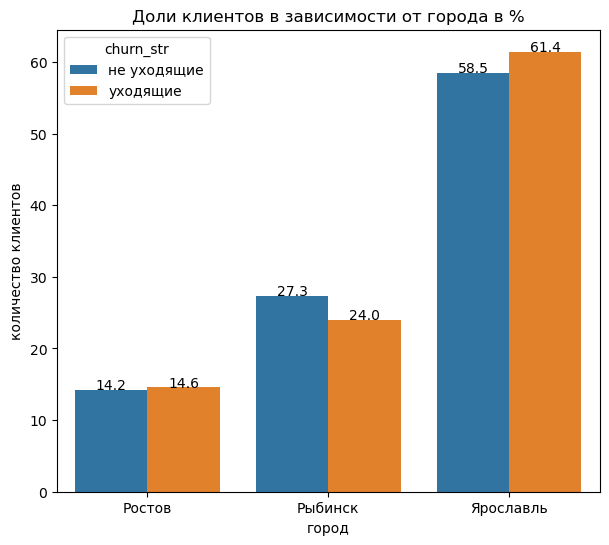

In [97]:
city_churn, city_churn_1 = churn_groups(data_initial, 'city')

plt.figure(figsize=(7, 6))
churn_bar(city_churn, city_churn['city'], city_churn['ratio'])
plt.ylabel('количество клиентов')
plt.xlabel('город')
plt.title("Доли клиентов в зависимости от города в %")
plt.show()

Так как в Ярославле больше всего клиентов, то ожидамо, что и уходящих клиентов там больше всего.

**Итог по подразделу. Можно составить портрет типичного отточного клиента.**

Для баланса и зарплаты возьмем медиану, для возраста и баллов скоринга - среднюю. Для остальных(категориальных) - моду.

In [98]:
print(f'Типичный уходящий клиент нашего банка проживает в Ярославле, имеет\
 возраст {round(description_table_1_churn.age[1],2)} года,\
 доход {round(description_table_1_churn.est_salary_th[5],2)} тысяч в месяц,\
 баланс на счете {round(description_table_1_churn.balance_th[5],2)} тысяч рублей.')

Типичный уходящий клиент нашего банка проживает в Ярославле, имеет возраст 41.43 года, доход 125.41 тысяч в месяц, баланс на счете 783.91 тысяч рублей.


In [99]:
print("Обычно это мужчина.\
 Чаще всего такой клиент имеет два банковских продукта и от 3 до 5 баллов собственности, владеет кредитной картой.")

Обычно это мужчина. Чаще всего такой клиент имеет два банковских продукта и от 3 до 5 баллов собственности, владеет кредитной картой.


In [100]:
typical_churn_1=pd.DataFrame(
{"показатель":["возраст", "пол", "город", "зп,т.р.", 
              "баланс,т.р.", "продукты", "собственность", "кредитная карта", "активность"],
 "значение":[41.43, "M", "Ярославль", 125.41, 783.91, 2, "от 3 до 5", "есть", "есть"]})
typical_churn_1

,показатель,значение
0,возраст,41.43
1,пол,M
2,город,Ярославль
3,"зп,т.р.",125.41
4,"баланс,т.р.",783.91
5,продукты,2
6,собственность,от 3 до 5
7,кредитная карта,есть
8,активность,есть


**Можно аналогичным образом построить портрет типичного не уходящего клиента.**

In [101]:
print(f'Типичный не уходящий клиент нашего банка проживает в Ярославле, имеет\
 возраст {round(description_table_0_churn.age[1],2)} года,\
 доход {round(description_table_0_churn.est_salary_th[5],2)} тысяч в месяц,\
 баланс на счете {round(description_table_0_churn.balance_th[5],2)} тысяч рублей.')

Типичный не уходящий клиент нашего банка проживает в Ярославле, имеет возраст 43.02 года, доход 118.25 тысяч в месяц, баланс на счете 475.35 тысяч рублей.


In [102]:
print("Обычно это мужчина.\
 Чаще всего такой клиент имеет два банковских продукта и 0 баллов собственности, владеет кредитной картой.")

Обычно это мужчина. Чаще всего такой клиент имеет два банковских продукта и 0 баллов собственности, владеет кредитной картой.


In [103]:
typical_churn_0=pd.DataFrame(
{"показатель":["возраст", "пол", "город", "зп,т.р.", 
              "баланс,т.р.", "продукты", "собственность", "кредитная карта", "активность"],
 "значение":[43.02, "Ж", "Ярославль", 118.25, 475.35, 2, 0, "есть", "нет"]})
typical_churn_0

,показатель,значение
0,возраст,43.02
1,пол,Ж
2,город,Ярославль
3,"зп,т.р.",118.25
4,"баланс,т.р.",475.35
5,продукты,2
6,собственность,0
7,кредитная карта,есть
8,активность,нет


## Посмотрим какие диапазоны показателей имеют наибольший отток клиентов

### Начнем с категориальных переменных

**Начнем с продуктов**.

Создадим ф-ию, которая поможет нам собрать данные для отрисовки графика с долями уходящих клиентов по каждому признаку.

In [104]:
def high_churn (df, column):
    churn_groups = df[df['churn']==1].groupby([column,'churn'])['user_id'].count().reset_index()
    churn_groups['sum'] = 0

    for idx, value in enumerate(churn_groups['sum']):
        churn_groups['sum'][idx]=df[df[column]==churn_groups[column][idx]]['user_id'].count()
        
    churn_groups['ratio'] = round(churn_groups['user_id'] / churn_groups['sum']*100)
    return churn_groups

In [105]:
churn_groups = high_churn(data, 'products')
#churn_groups

Создадим ф-ию для отрисовки графика.

In [106]:
def churn_bar (df, x_axis, y_axis):
    ax = sns.barplot(
    data=df, x=x_axis, 
    y=y_axis)

    for p in ax.patches:
        height = p.get_height() 
        ax.text(x = p.get_x()+(p.get_width()/2), 
        y = height+0.05, 
        s = '{:.1f}'.format(height), 
        ha = 'center') 
    return ax

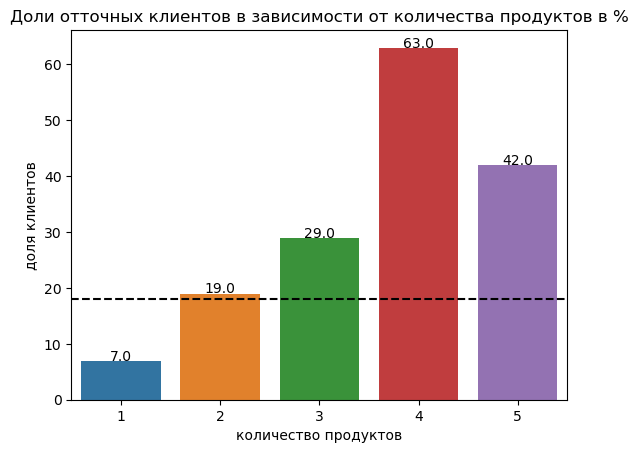

In [107]:
churn_bar(churn_groups, 'products', 'ratio')
plt.ylabel('доля клиентов')
plt.xlabel('количество продуктов')
plt.title("Доли отточных клиентов в зависимости от количества продуктов в %")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
plt.show()

Пунктирная линия показывает средний уровень оттока по данным в целом. Мы видим, что превышают среднее значений клиенты с 2,3,4,5 продуктами. Возможно, наш банк пока не так удобен для тех, кто активно использует банковские продукты.
Посмотрим насколько разница между долей клиентов с 2 продуктами и средним по датасету статистически значима.

Нулевая гипотеза: нет статистически значимой разницы между долей уходящих клиентов с 2 продуктами и средней долей уходящих клиентов.\
Альтернативная гипотзеа: статистически значимая разница есть.\
Напишем ф-ию для z-теста для пропорций.

In [108]:
def proportion_z_test (data, column, variable):
    variable_churn = data.loc[(data[column]==variable)&(data['churn']==1)]["user_id"].count()
    variable_total = data[data[column]==variable]["user_id"].count()
    all_churn = data.loc[data['churn']==1]["user_id"].count()
    all_data = data["user_id"].count()
    
    alpha = 0.05
    count = [variable_churn, all_churn]
    nobs = [variable_total, all_data]
    stat, p_value = proportions_ztest(count, nobs)

    print('p-значение: ', p_value)

    if p_value < alpha: 
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')

In [109]:
proportion_z_test (data, 'products', 2)

p-значение:  0.19349933239685313
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Получается, что серьезные различия со средним значением только у групп клиентов с 3,4,5 продуктами.

**Проделаем такой же анализ для баллов собственности**.

In [110]:
churn_groups = high_churn(data, 'equity')
#churn_groups

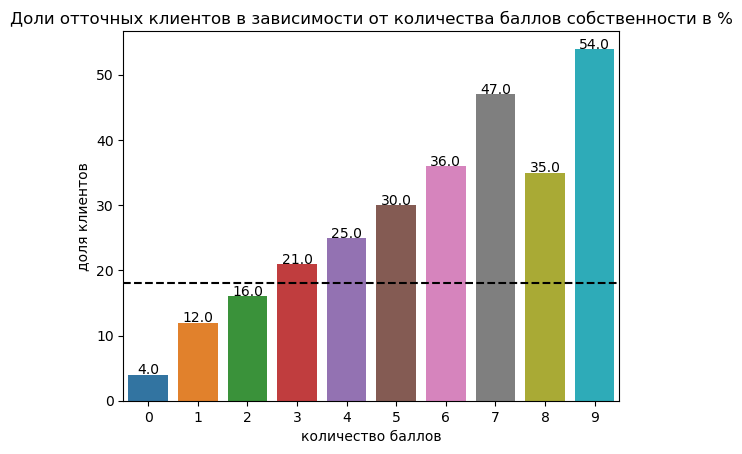

In [111]:
churn_bar(churn_groups, 'equity', 'ratio')

plt.ylabel('доля клиентов')
plt.xlabel('количество баллов')
plt.title("Доли отточных клиентов в зависимости от количества баллов собственности в %")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
plt.show()

Пунктирная линия показывает средний уровень оттока по данным в целом. Мы видим, что превышают среднее значений клиенты с 3 и более баллами. Возможно, наш банк пока не так удобен для для более состоятельных клиентов.
Посмотрим насколько разница между долей клиентов с 3 баллами и средним по датасету статистически значима.

Нулевая гипотеза: нет статистически значимой разницы между долей уходящих клиентов с 3 баллами и средней долей уходящих клиентов.\
Альтернативная гипотзеа: статистически значимая разница есть.

In [112]:
proportion_z_test (data, 'equity', 3)

p-значение:  0.013489838514100204
Отвергаем нулевую гипотезу: между долями есть значимая разница.


Получается, что клиенты с 3 баллами имеют значимо более высокую долю оттока. Клиенты с еще более высокими баллами имеют еще большие оттоки.

**Теперь для городов.**

In [113]:
churn_groups = high_churn(data_initial, 'city')
#churn_groups

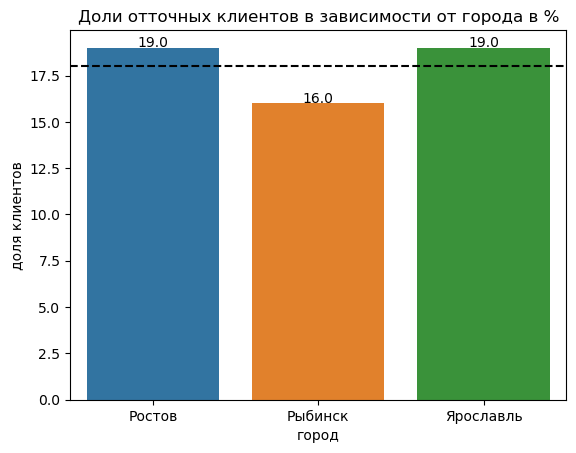

In [114]:
churn_bar(churn_groups, 'city', 'ratio')

plt.ylabel('доля клиентов')
plt.xlabel('город')
plt.title("Доли отточных клиентов в зависимости от города в %")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
plt.show()

Пунктирная линия показывает средний уровень оттока по данным в целом. Мы видим, что немного превышают среднее значений клиенты с из Ростова и Ярославля. Но недостаточно, чтобы из них можно было сформировать категорию клиентов с очень сильным оттоком.

**Теперь для пола.**

In [115]:
churn_groups = high_churn(data_initial, 'gender')
#churn_groups

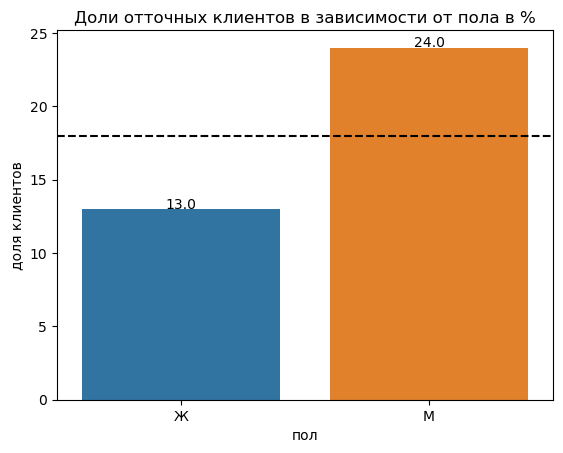

In [116]:
churn_bar(churn_groups, 'gender', 'ratio')

plt.ylabel('доля клиентов')
plt.xlabel('пол')
plt.title("Доли отточных клиентов в зависимости от пола в %")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
plt.show()

Доля отточных клиентов среди мужчин превышает среднее значение в 18%. Узнаем, насколько это статистически значимо. 

Нулевая гипотеза: нет статистически значимой разницы между долей уходящих клиентов среди мужчин и средней долей уходящих клиентов.\
Альтернативная гипотзеа: статистически значимая разница есть.

In [117]:
proportion_z_test (data_initial, 'gender', 'М')

p-значение:  3.8070327817630806e-15
Отвергаем нулевую гипотезу: между долями есть значимая разница.


Разница значима и можно предположить, что готовых уйти из банка клиентов мужчин значимо больше, чем в среднем.

**Теперь для кредитных карт.**

In [118]:
churn_groups = high_churn(data, 'credit_card')
churn_groups

,credit_card,churn,user_id,sum,ratio
0,0,1,815,3174,26.0
1,1,1,1003,6748,15.0


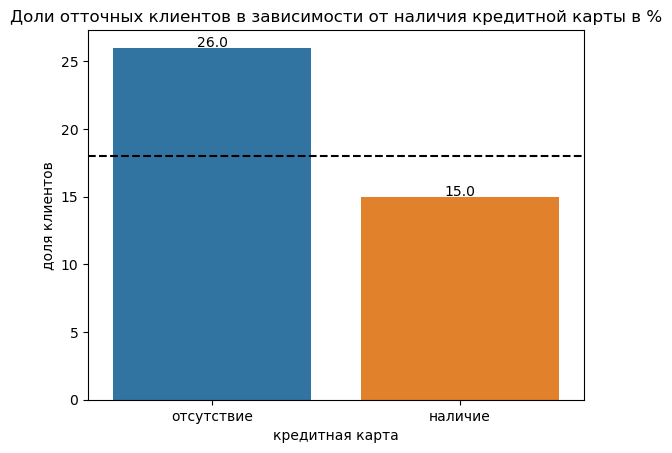

In [119]:
churn_bar(churn_groups, 'credit_card', 'ratio')

plt.ylabel('доля клиентов')
plt.xlabel('кредитная карта')
plt.title("Доли отточных клиентов в зависимости от наличия кредитной карты в %")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
labels = ['отсутствие','наличие']
plt.xticks([0,1], labels)
plt.show()

In [120]:
print(f'Видим, что люди без кредитной карты примерно\
 в {round(churn_groups.ratio[0]/(data.churn.mean()*100),2)} раза чаще, чем в среднем близки к уходу из банка.')

Видим, что люди без кредитной карты примерно в 1.42 раза чаще, чем в среднем близки к уходу из банка.


**Теперь для значимой активности.**

In [121]:
churn_groups = high_churn(data, 'last_activity')
churn_groups

,last_activity,churn,user_id,sum,ratio
0,0,1,541,4729,11.0
1,1,1,1277,5193,25.0


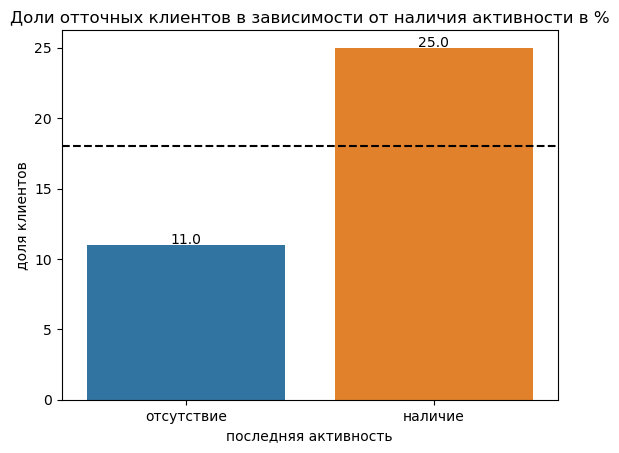

In [122]:
churn_bar(churn_groups, 'last_activity', 'ratio')

plt.ylabel('доля клиентов')
plt.xlabel('последняя активность')
plt.title("Доли отточных клиентов в зависимости от наличия активности в %")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
labels = ['отсутствие','наличие']
plt.xticks([0,1], labels)
plt.show()

In [123]:
print(f'Видим, что люди с недавней значимой активностью примерно\
 в {round(churn_groups.ratio[1]/(data.churn.mean()*100),2)} раза чаще, чем в среднем близки к уходу из банка.')

Видим, что люди с недавней значимой активностью примерно в 1.36 раза чаще, чем в среднем близки к уходу из банка.


**Промежуточный вывод. Можно выделить наиболее проблемные области для разных показателей.**

* Серьезно превышают среднее значение по датасету, как минимум в 1,6 раза, клиенты с 3,4,5 продуктами.
* Клиенты с 3 баллами собственности имеют долю оттока на 16% выше, чем в среднем. Клиенты с 4 баллами на 38% выше. Клиенты с еще большим кол-вом баллов минимум на 66% в зависимости от баллов.
* По городам все очень близко к среднему, нет существенных различий.
* Доля отточных клиентов среди мужчин превышает среднее значение в 18%.
* Люди без кредитной карты примерно в 1.42 раза чаще являются отточными.
* Люди с недавней значимой активностью примерно в 1.36 раза чаще, чем в среднем близки к уходу из банка.

### Сравним распределения плотностей непрерывных признаков: зарплата и баланс

Как обычно смотрим в тысячах рублей.\
**Начнем с зарплаты.**

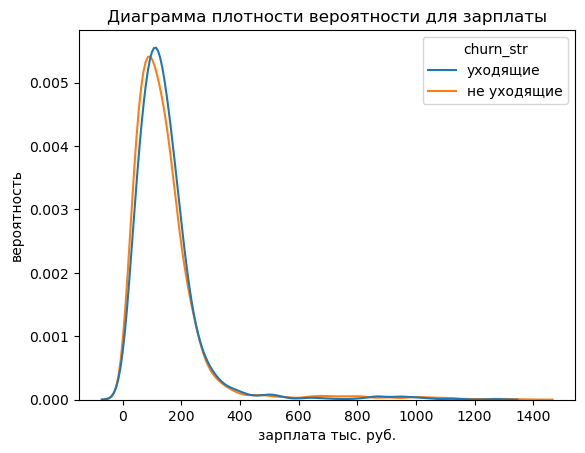

In [124]:
sns.kdeplot(data=data, x='est_salary_th', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для зарплаты')
plt.ylabel('вероятность')
plt.xlabel('зарплата тыс. руб.')
plt.show()

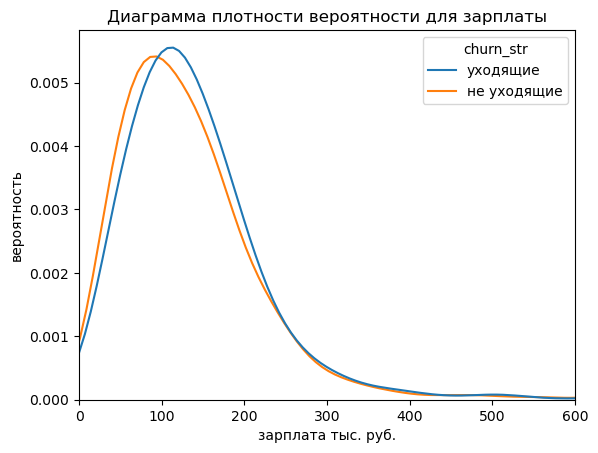

In [125]:
sns.kdeplot(data=data, x='est_salary_th', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для зарплаты')
plt.ylabel('вероятность')
plt.xlabel('зарплата тыс. руб.')
plt.xlim(0, 600)
plt.show()

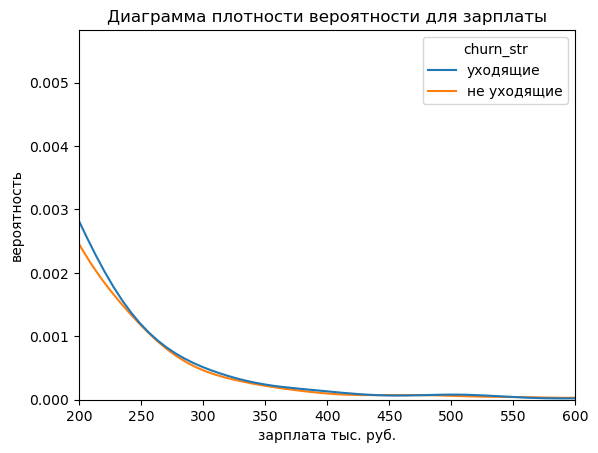

In [126]:
sns.kdeplot(data=data, x='est_salary_th', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для зарплаты')
plt.ylabel('вероятность')
plt.xlabel('зарплата тыс. руб.')
plt.xlim(200, 600)
plt.show()

Диаграмма для отточных клиентов смещена немного вправо. Исходя из этого можно выделить три группы клиентов:
* Клиенты с зп до 100 т.р. у которых вероятности оттока ниже, чем в среднем по датасету.
* Клиенты с зп от 100 до 250 т.р. у которых вероятности оттока выше, чем в среднем по датасету для этой группы.
* Клиенты с зп от 250 т.р. и выше у которых вероятность оттока примерно равна для отточных и неотточных.\
Получается, что проблемная область - клиенты с зп от 100 до 250 т.р.

**Изучим распределения для баланса.**

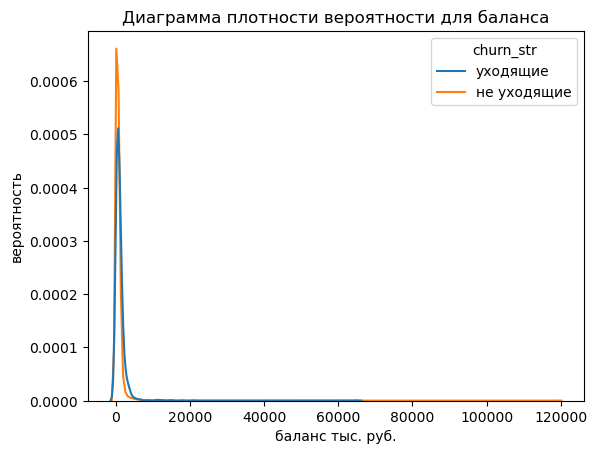

In [127]:
sns.kdeplot(data=data, x='balance_th', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для баланса')
plt.ylabel('вероятность')
plt.xlabel('баланс тыс. руб.')
plt.show()

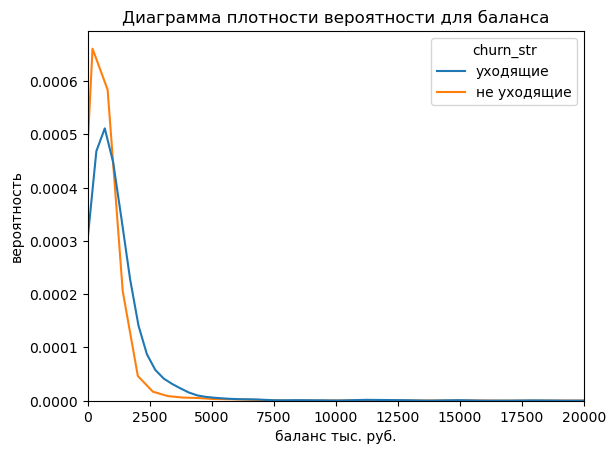

In [128]:
sns.kdeplot(data=data, x='balance_th', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для баланса')
plt.ylabel('вероятность')
plt.xlabel('баланс тыс. руб.')
plt.xlim(0, 20000)
plt.show()

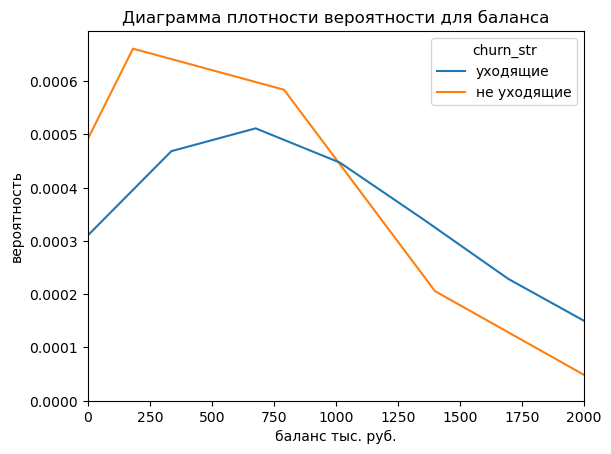

In [129]:
sns.kdeplot(data=data, x='balance_th', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для баланса')
plt.ylabel('вероятность')
plt.xlabel('баланс тыс. руб.')
plt.xlim(0, 2000)
plt.show()

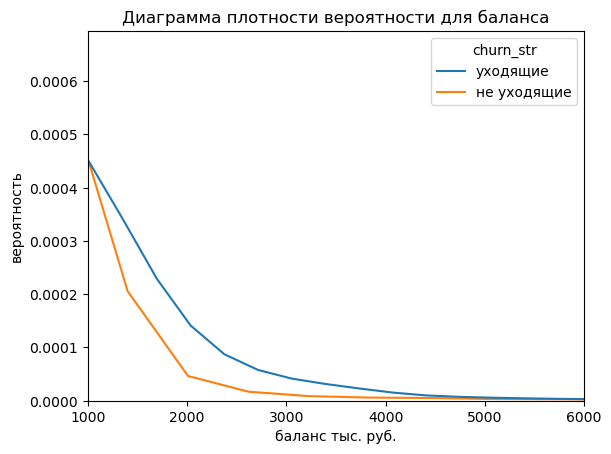

In [130]:
sns.kdeplot(data=data, x='balance_th', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для баланса')
plt.ylabel('вероятность')
plt.xlabel('баланс тыс. руб.')
plt.xlim(1000, 6000)
plt.show()

Диаграмма для отточных клиентов имеет более высокие значения справа. Исходя из этого можно выделить две группы клиентов:
* Клиенты с балансом до 1 млн.р., у которых вероятности оттока ниже, чем в среднем по датасету.
* Клиенты с балансом от 1 млн.р. до 4,5 млн.р., у которых вероятности оттока выше, чем в среднем по датасету.
* Клиенты с балансом от 4,5 млн. р., у которых вероятность оттока как в среднем по датасету.

**Вывод к подразделу. Можно выделить такие проблемные интервалы для признаков.**


* По признаку зарплаты проблемная область - клиенты с зп от 100 до 250 т.р.
* По признаку баланса проблемные области - клиенты с балансом от 1 млн.р. до 4,5 млн.р.

Таких людей нельзя назвать очень богатыми, но у них есть капитал и доход выше среднего, значит, они активно пользуются банковскими продуктами. Например, кэшбеки, накопление миль за покупки, проценты на остаток по банковской карте, однозначно они пользуются накопительными счетами, вкладами.\
Возможно, им будут интересны страховые продукты, например, страхование в путешествиях, страхование имущества, в т.ч. автомобиля и недвижимости.

### Сравним распределения плотностей дискретных признаков: оценка кредитного скоринга и возраст

**Начнем с возраста**.

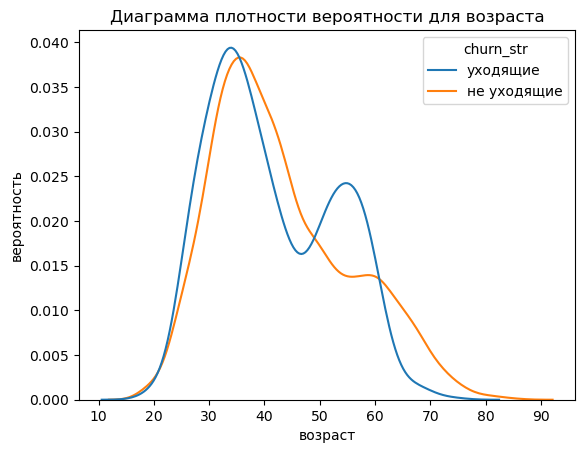

In [131]:
sns.kdeplot(data=data, x='age', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для возраста')
plt.ylabel('вероятность')
plt.xlabel('возраст')
plt.show()

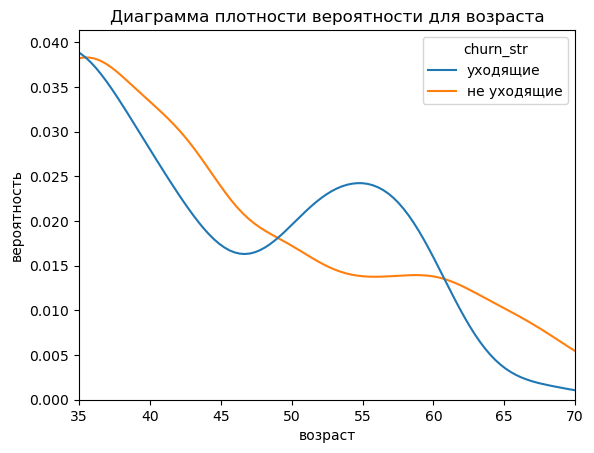

In [132]:
sns.kdeplot(data=data, x='age', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для возраста')
plt.ylabel('вероятность')
plt.xlabel('возраст')
plt.xlim(35, 70)
plt.show()

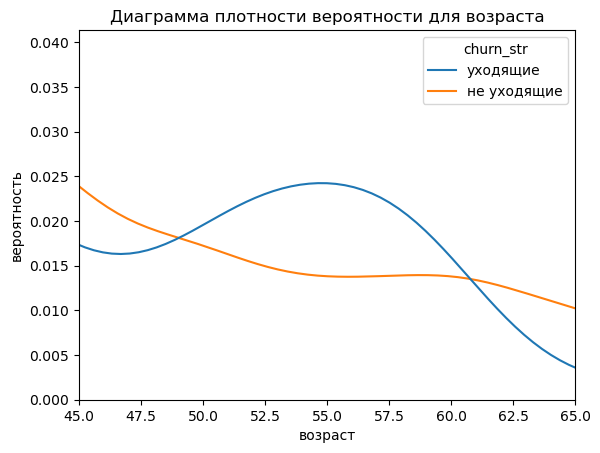

In [133]:
sns.kdeplot(data=data, x='age', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для возраста')
plt.ylabel('вероятность')
plt.xlabel('возраст')
plt.xlim(45, 65)
plt.show()

Можно разделить данные несколько групп:
* Клиенты до 35 лет чаще, чем в среднем по всем данным планируют уйти из банка.
* Клиенты от 35 до 49 лет реже, чем в среднем уходят из банка.
* Клиенты от 49 до 61 снова чаше обычного не лояльны.
* Клиенты старше 61 года чаще не уходящие, чем в среднем по датасету.

**Теперь баллы кредитного скоринга**.

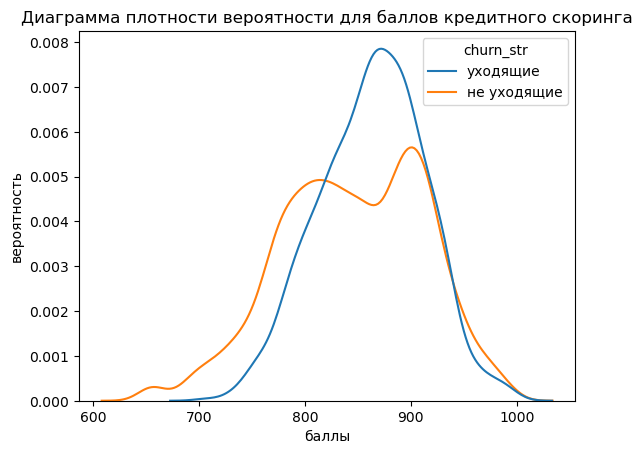

In [134]:
sns.kdeplot(data=data, x='score', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для баллов кредитного скоринга')
plt.ylabel('вероятность')
plt.xlabel('баллы')
plt.show()

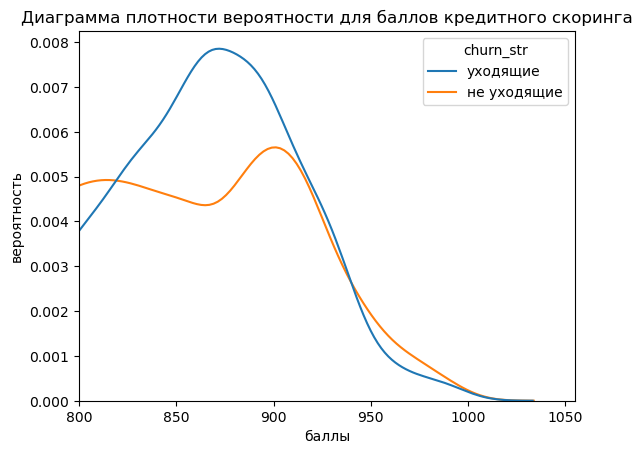

In [135]:
sns.kdeplot(data=data, x='score', common_norm=False, hue='churn_str')
plt.title('Диаграмма плотности вероятности для баллов кредитного скоринга')
plt.ylabel('вероятность')
plt.xlabel('баллы')
plt.xlim(800)
plt.show()

Можно разделить данные несколько групп:
* Клиенты, у кого до 820 быллов реже, чем в среднем по данным планируют уйти из банка.
* Клиенты, у кого от 820 быллов до 930 баллов чаще, чем в среднем по данным планируют уйти из банка.
* Клиенты, у кого от 930 баллов реже чем в среднем готовы уйти из банка.

**Вывод к подразделу. Можно выделить такие проблемные интервалы для признаков.**


* По признаку возраста проблемные области - клиенты до 35 и от 49 лет до 61.
* По признаку баллов кредитного скоринга проблемная область - клиенты, у кого от 820 до 930 баллов.

Если соединить с выводами к подразделу с зп и балансом, то клиентами с возрасом до 35 могут быть интересны карты с кэшбеками, накопление миль, какие-то инвестиционные продукты.\
Людям от 49 до 61 года могут быть интересны какие-то семейные пакеты обслуживания в банке, в том числе страховки для членов семьи, возможно, дебитовые карты для всех членов семьи, привязанные к одному банковскому счету.

### Сравним средние значения для отточных и не отточных признаков для непрерывных и дискретных переменных

**Начнем с зарплаты.**

In [136]:
data.head()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missing_balance,rostov,rybinsk,yaroslavl,female,male,est_salary_th,balance_th,churn_str
0,183012,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,0,1,0,1,0,75.71914,59.21482,уходящие
1,146556,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,0,1,0,1,0,86.62177,850.59433,не уходящие
2,120722,892.0,30.0,0,NaN,1,1,1,107683.34,0,1,0,1,0,1,0,107.68334,NaN,не уходящие
3,225363,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,0,1,1,0,174.42353,1524.74626,уходящие
4,157978,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,0,1,0,1,67.35316,0.17400,уходящие


У нас есть проблемная группа - это отточные клиенты с зп от 100 до 250 тр. Посмотрим на их среднюю, общую среднюю и среднюю среди отточных клиетнов.

Создадим ф-ию, которая будет делать таблицу с 4-мя значениями:
* средним значением по неотточным;
* среднем по отточным; 
* средним для проблемной группы среди отточных;
* средним по отточным за исключением проблемной группы.

In [137]:
def mean_comparison (column, number_1, number_2):
    
    no_churn_mean = data[data['churn']==0][column].mean()
    
    churn_mean = data[data['churn']==1][column].mean()
    
    problem = data.loc[(data[column]<=number_2)&(data[column]>=number_1)]
    problem = problem[problem["churn"]==1][column].mean()
    
    no_problem = data.loc[(data[column]<=number_2)&(data[column]>=number_1)][column]
    no_problem = data[~data[column].isin(no_problem)]
    churn_no_problem = no_problem[no_problem["churn"]==1][column].mean()
    
    mean = pd.DataFrame(
    {'показатель':['среднее неотточных', 'среднее отточных', 
               'среднее для проблемных отточных', 'среднее по отточным за исключением проблемной группы'],
     'значение':[no_churn_mean, churn_mean, problem, churn_no_problem]})
    
    plt.figure(figsize=(11,6))
    ax = sns.barplot(
    data = mean, x='показатель', y='значение')
    for p in ax.patches:
        height = p.get_height() 
        ax.text(x = p.get_x()+(p.get_width()/2), 
        y = height+0.05, 
        s = '{:.1f}'.format(height), 
        ha = 'center')

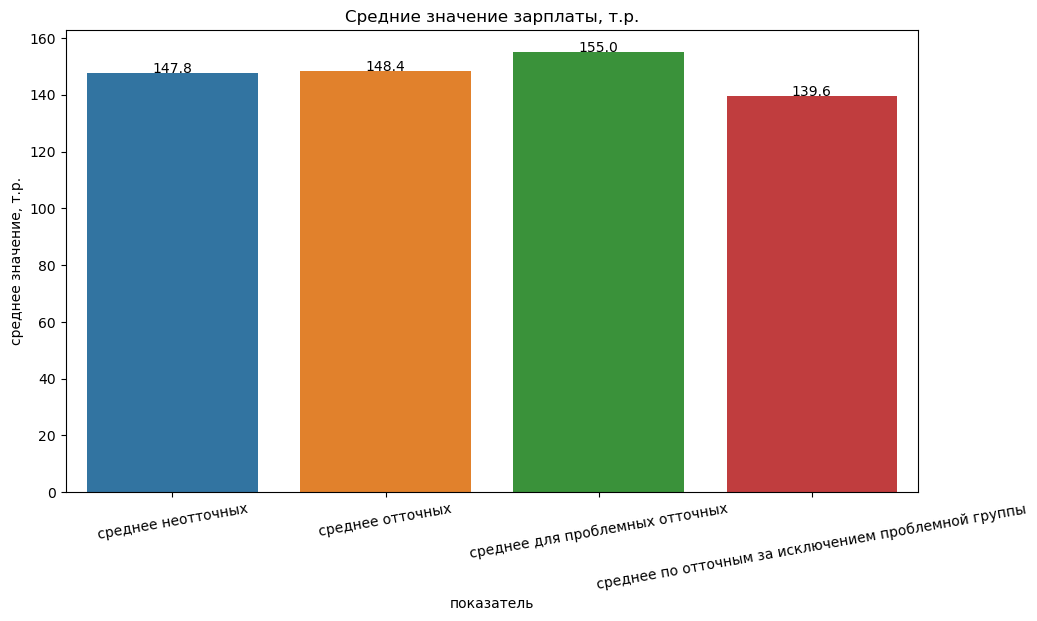

In [138]:
mean_comparison('est_salary_th', 100, 250)
plt.ylabel('среднее значение, т.р.')
plt.title("Средние значение зарплаты, т.р.")
plt.xticks(rotation=10)
plt.show()

Разница между значениями невысокая, поэтому нельзя без теста утверждать, что по зп мы можем явно выявить отточных.
Будем сравнивать среднее по отточным с неотточными. А также среднее для проблемных отточных с остальными отточными. 

**Теперь посчитаем для баланса.**

По признаку баланса проблемная область - отточные клиенты с балансом от 1 млн.р. до 4,5 млн.р. Посмотрим на средний баланс для данной обалсти, а также общий средний баланс и средний баланс среди отточных.

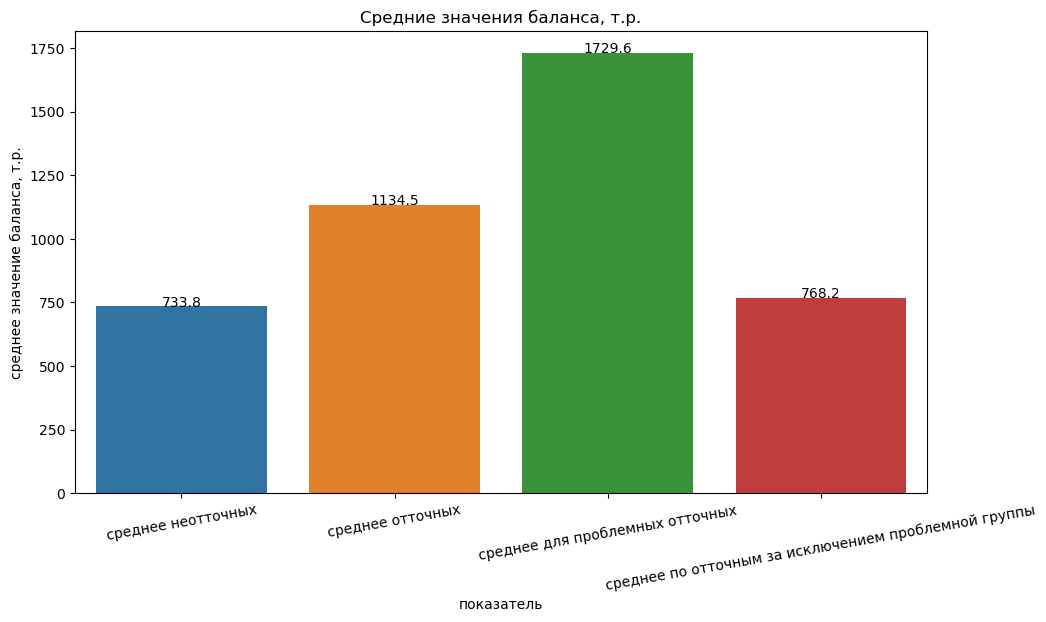

In [139]:
mean_comparison('balance_th', 1000, 4500)
plt.ylabel('среднее значение баланса, т.р.')
plt.title("Средние значения баланса, т.р.")
plt.xticks(rotation=10)
plt.show()

In [140]:
print(f'Средний баланс среди отточных клиентов выше среднего для неотточных\
 в {round(1134.5/733.8,2)} раза. Для клиентов с балансом от 1 до 4,5 млн.среднее\
 в {round(1729.6/768.2,2)} раза больше, чем среднее по остальным отточным.')

Средний баланс среди отточных клиентов выше среднего для неотточных в 1.55 раза. Для клиентов с балансом от 1 до 4,5 млн.среднее в 2.25 раза больше, чем среднее по остальным отточным.


Тут разница большая у всех значений. Особенно большая разница у среднего отточных клиентов с балансом от 1 до 4,5 млн.р. и остальных отточных. Значит, отточные клиенты с балансом от 1 до 4,5 млн.р. - это признак, который хорошо характеризует людей, кто может уйти из банка.

**Теперь посчитаем для оценок скоринга.**

По признаку баллов кредитного скоринга проблемная область - клиенты, у кого от 820 до 930 баллов.

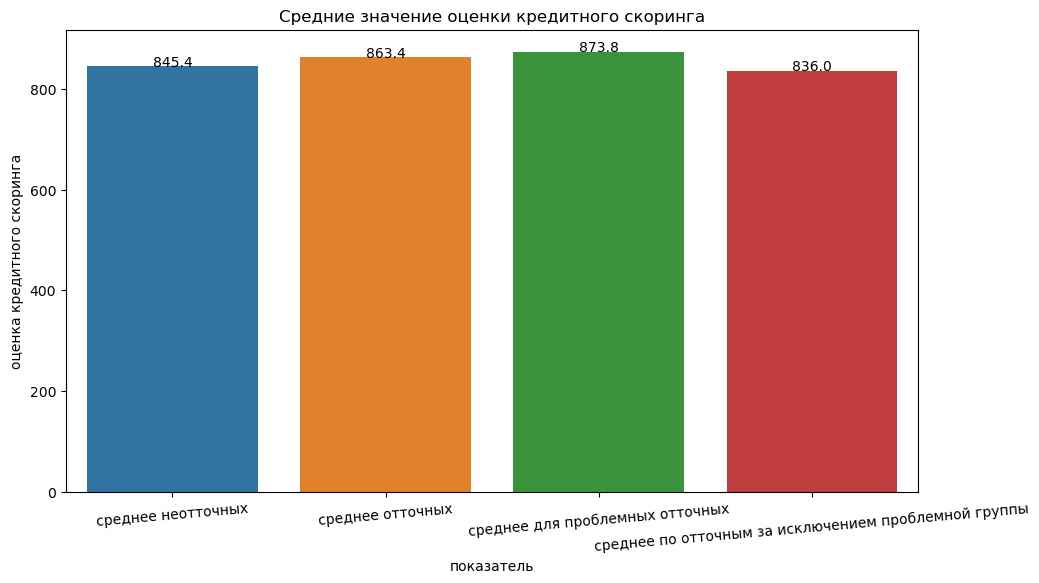

In [141]:
mean_comparison('score', 820, 930)
plt.ylabel('оценка кредитного скоринга')
plt.title("Средние значение оценки кредитного скоринга")
plt.xticks(rotation=5)
plt.show()

In [142]:
print(f'Средний балл скоринга среди отточных клиентов выше неотточного\
 среднего в {round(863.4/845.4,2)} раза, а для отточных клиентов с баллом от 820 до 930 млн.среднее\
 в {round(873.8/863,2)} раза больше, чем по остальным отточным.')

Средний балл скоринга среди отточных клиентов выше неотточного среднего в 1.02 раза, а для отточных клиентов с баллом от 820 до 930 млн.среднее в 1.01 раза больше, чем по остальным отточным.


Разница минимальная. Надо будет в дальнейшем проверить гипотезу, значимо ли средний балл скоринга для отточных с баллом 820-930 отлиается от среднего балла для остальных отточных. Если значимо, то можно считать, что это важный признак, характерезующий отточных клиентов. Если нет, то этот признак не скажет нам отточный клиент или нет.

**Теперь посчитаем для возраста.**

По признаку возраста проблемные области - клиенты до 35 и от 49 лет до 61. У нас тут две проблемные зоны, поэтому прежняя ф-ия не подойдет.

In [143]:
no_churn_mean = data[data['churn']==0]['age'].mean()
churn_mean = data[data['churn']==1]['age'].mean()

problem_1 = data.query('age<=35 and churn==1')['age'].mean()
problem_2 = data.query('49<=age<=61 and churn==1')['age'].mean()

no_problem_1 = data.loc[data['age']<=35]['age']
no_problem_1 = data[~data['age'].isin(no_problem_1)]
churn_no_problem_1 = no_problem_1[no_problem_1["churn"]==1]['age'].mean()

no_problem_2 = data.loc[(data['age']<=61)&(data['age']>=49)]['age']
no_problem_2 = data[~data['age'].isin(no_problem_2)]
churn_no_problem_2 = no_problem_2[no_problem_2["churn"]==1]['age'].mean()

mean_1 = pd.DataFrame(
    {'показатель':['среднее неотточных', 'среднее отточных'],
     'значение':[no_churn_mean, churn_mean]})

mean_2 = pd.DataFrame(
    {'показатель':['среднее отточных в возрасте до 35 вкл.', 'среднее отточных в возрасте от 49 до 61 вкл.',
               'среднее отточных старше 35', 'среднее отточных младше 49 и старше 61'],
     'значение':[problem_1, problem_2, churn_no_problem_1, churn_no_problem_2]})

In [144]:
display(mean_1)
mean_2

,показатель,значение
0,среднее неотточных,43.016288
1,среднее отточных,41.429593


,показатель,значение
0,среднее отточных в возрасте до 35 вкл.,30.439655
1,среднее отточных в возрасте от 49 до 61 вкл.,54.827853
2,среднее отточных старше 35,48.246881
3,среднее отточных младше 49 и старше 61,36.105304


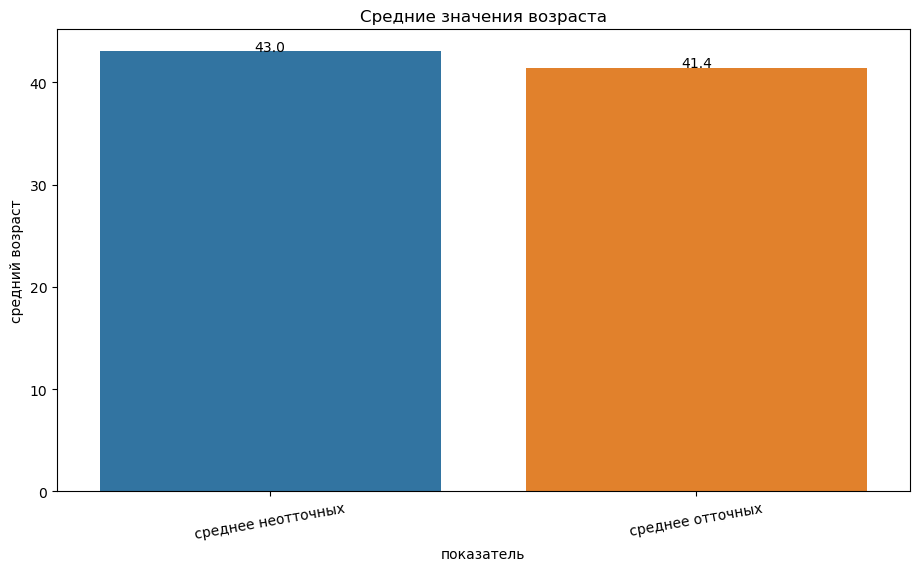

In [145]:
plt.figure(figsize=(11,6))
ax = sns.barplot(
data = mean_1, x='показатель', y='значение')
for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center') 
    
plt.ylabel('средний возраст')
plt.title("Средние значения возраста")
plt.xticks(rotation=10)
plt.show()

Получается, что разница между отточными и не отточными очень мала. Надо проверять значимость тестом. Посмотрим на средние проблемных групп.

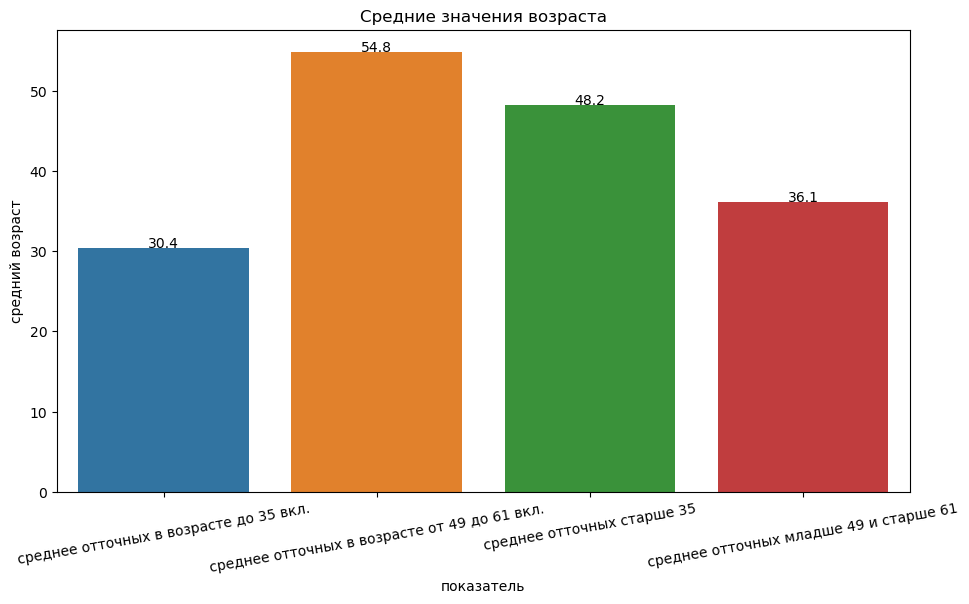

In [146]:
plt.figure(figsize=(11,6))
ax = sns.barplot(
data = mean_2, x='показатель', y='значение')
for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center') 
    
plt.ylabel('средний возраст')
plt.title("Средние значения возраста")
plt.xticks(rotation=10)
plt.show()

Но проблемные категории по возрасту достаточно далеко находятся от среднего остальных отточных.\
В частности средний возраст отточных до 35 лет ниже среднего возраста отточных старше 35 лет в 1,59 раза.\
Среднее отточных от 49 до 61 выше среднего остальных отточных в 1,52 раза.
Для таких различий на статистические тесты не нужны.

## Корреляции

Посмотрим как коррелирует значение столбца "churn" с другими столбцами.

In [147]:
data_phik = data_initial.set_index("user_id")

# Удалим добавленный ранее столбец, который дублирует исходные данные
data_phik = data_phik.drop(columns = ['churn_str'],axis = 1)

In [148]:
interval_cols = ['score', 'age', 'balance', 'est_salary']

phik_overview = data_phik.phik_matrix(interval_cols=interval_cols)

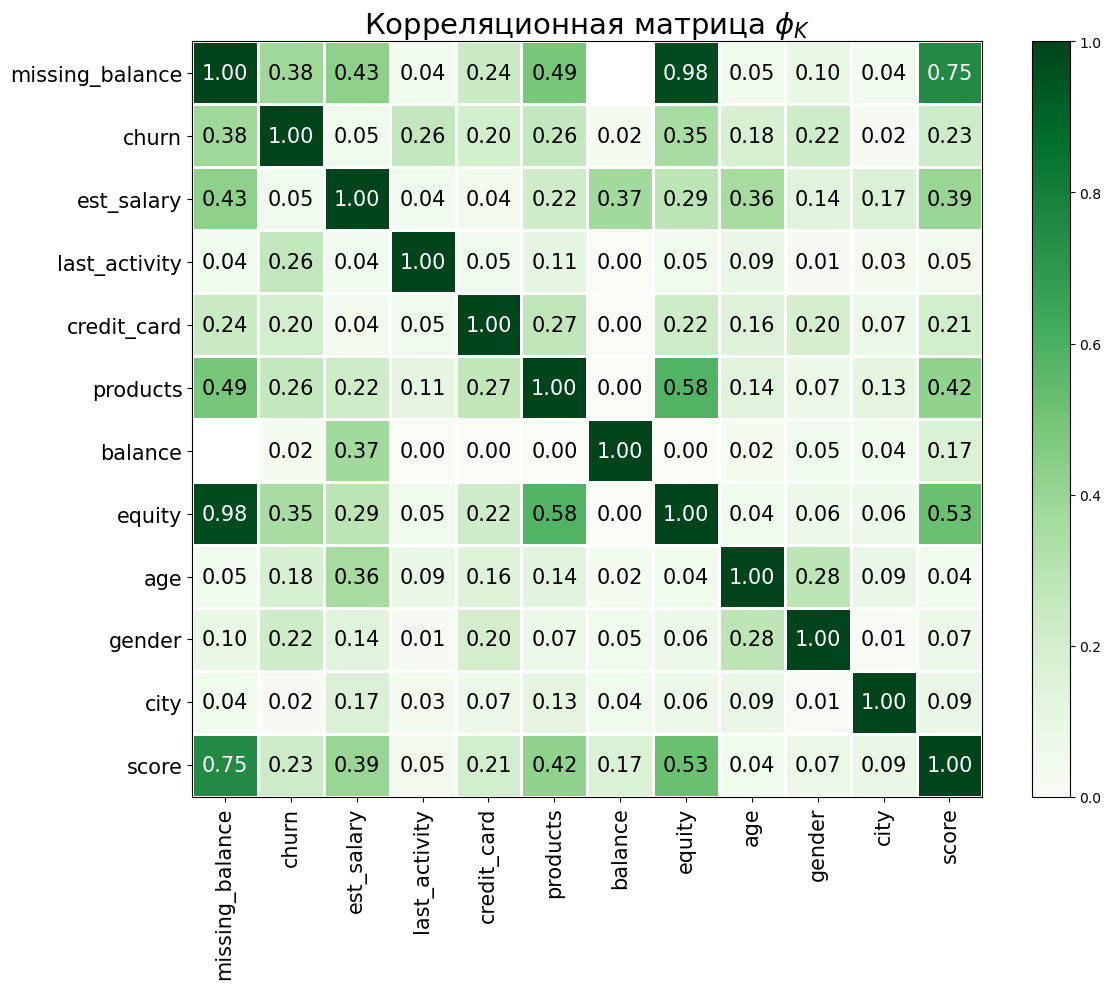

In [149]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляционная матрица $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(12, 10))
plt.tight_layout()

In [150]:
From = 0.5
To = 10.5
Step = 1
ticks_position = np.arange(From, To, Step)
ticks_name =['город', 'баланса', 'зарплата', 'возраст', 
        'кр.карта', 'пол', 'оценка скоринга', 'кол-во продуктов', 'последняя активность', 'баллы собственности']
ticks_name=ticks_name[::-1]

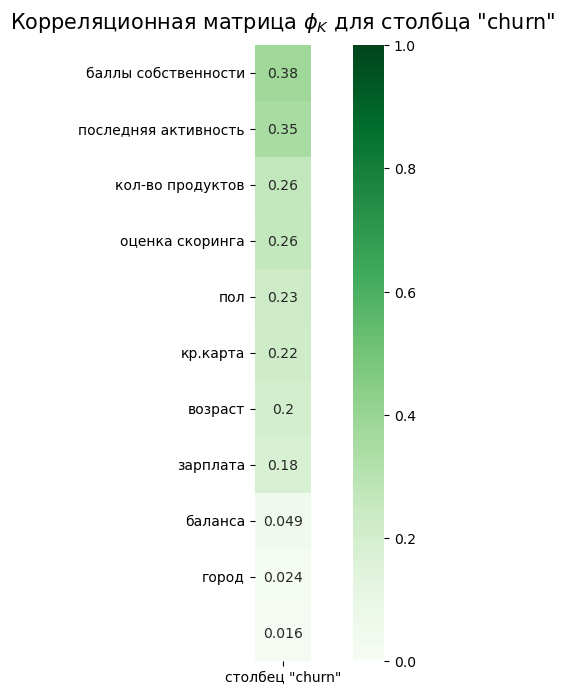

In [151]:
plt.figure(figsize=(11,8))
ax = sns.heatmap(phik_overview[['churn']].sort_values(by='churn', ascending=False).drop(labels = ['churn'],axis = 0),
    cmap="Greens", annot=True,
    vmin=0, vmax=1.0,
    square=True)
ax.set_title('Корреляционная матрица $\phi_K$ для столбца "churn"', fontdict={'fontsize':15}, pad=12)
plt.yticks(ticks_position, ticks_name)
plt.xticks([0.5],['столбец "churn"'])
plt.show()

Обработаем матрицу, чтобы избавиться от дублирующих значений.

In [152]:
mask = np.zeros_like(phik_overview, dtype=bool)
mask[np.triu_indices_from(mask)] = True
phik_overview[mask] = np.nan

In [153]:
phik_overview = phik_overview.drop(['score'], axis=0).drop(['churn'], axis=1)

In [154]:
x_ticks_name=['скоринг', 'город', 'пол', 'возраст', 'собственность', 
        'баланс', 'кол-во продуктов', 'кр.карта', 'активность', 'зарплата']
y_ticks_name=['город', 'пол', 'возраст', 'собственность', 
        'баланс', 'кол-во продуктов', 'кр.карта', 'активность', 'зарплата', 'отточность']

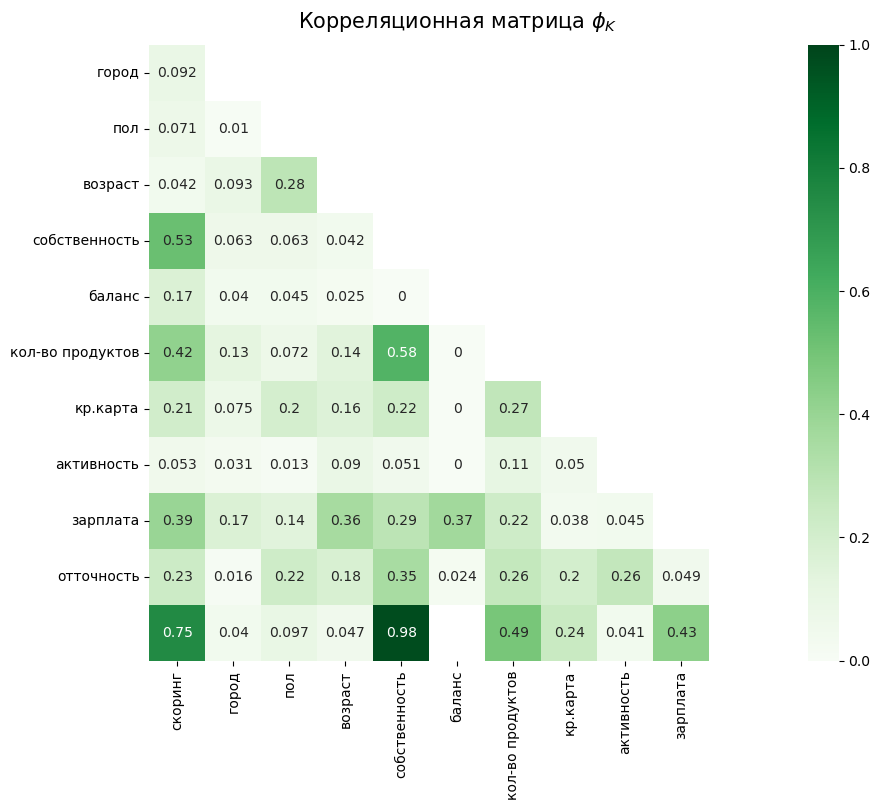

In [155]:
plt.figure(figsize=(11,8))
ax = sns.heatmap(phik_overview,
    cmap="Greens", annot=True,
    vmin=0, vmax=1.0,
    square=True, yticklabels=y_ticks_name, xticklabels=x_ticks_name)
ax.set_title('Корреляционная матрица $\phi_K$', fontdict={'fontsize':15}, pad=12)
plt.show()

Видим, что наибольшая связь у столбца оттока/не оттока с баллами собственности.\
Также выше 0.1 связь с оценкой скоринга, полом, возрастом, количеством продуктов, наличием кредитной карты, последней активностью.\
Оценка скоринга - это определенный алгоритм, если он включает похожие параметры, что и оценка отточности, то этим в том числе может быть обусловлена связь эти столбцов.

## Выводы к разделу 

* Серьезно превышают среднее значение по датасету, как минимум в 1,6 раза, клиенты с 3,4,5 продуктами.
* Клиенты с 3 баллами собственности имеют долю оттока на 16% выше, чем в среднем. Клиенты с 4 баллами на 38% выше. Клиенты с еще большим кол-вом баллов минимум на 66% в зависимости от баллов.
* По городам все очень близко к среднему, нет существенных различий.
* Доля отточных клиентов среди мужчин превышает среднее значение на 18%.
* Люди без кредитной карты примерно в 1.42 раза чаще являются отточными.
* Люди с недавней значимой активностью примерно в 1.36 раза чаще, чем в среднем близки к уходу из банка.

* По признаку зарплаты проблемная область - клиенты с зп от 100 до 250 т.р.\
Тем не менее, средняя зарплата проблемных отточных и остальных отточных очень близки друг к другу. Надо проверить значимость различий. 
 
* По признаку баланса проблемные области - клиенты с балансом от 1 млн.р. до 4,5 млн.р.\
Средний баланс среди отточных клиентов выше среднего для неотточных в 1.55 раза. Для клиентов с балансом от 1 до 4,5 млн.среднее в 2.25 раза больше, чем среднее по остальным отточным.\
Значит, отточные клиенты с балансом от 1 до 4,5 млн.р. - это признак, который хорошо характеризует людей, кто может уйти из банка.

* По признаку возраста проблемные области - клиенты до 35 вкл. и от 49 лет до 61 вкл.\
Разница между отточными и не отточными очень мала. Но проблемные категории по возрасту достаточно далеко находятся от среднего среди остальных отточных. Значит эти категории вполне можно использовать при создании портрета отточного клиента.
* По признаку баллов кредитного скоринга проблемная область - клиенты, у кого от 820 вкл. до 930 баллов вкл.\
Средний балл скоринга среди отточных клиентов выше неотточного среднего в 1.02 раза, а для отточных клиентов с баллом от 820 до 930 млн.среднее в 1.01 раза больше, чем по остальным отточным.\
Разница минимальная. Надо будет в дальнейшем проверить значимость различий. Если значимо, то можно считать, что это важный признак, характерезующий отточных клиентов. Если нет, то этот признак не четко характерезует отточных клиентов.

В качестве дополнительных размышлений: \
Области с наибольшим оттоком говорят о том, что клиентам с зарплатами выше среднего, имеющими собственность и определенные накопления что-то не нравится в нашем банке. При этом это активные пользователи банковских продуктов.\
Клиентами с возрасом до 35 могут быть интересны карты с кэшбеками, накопление миль, какие-то инвестиционные продукты.\
Людям от 49 до 61 года могут быть интересны какие-то семейные пакеты обслуживания в банке, в том числе страховки для членов семьи, возможно, дебитовые карты для всех членов семьи, привязанные к одному банковскому счету.

# Проверка гипотез

## Зарплата

У нас есть три средних значениях зарплаты.

In [156]:
def mean_comparison (column, number_1, number_2):
    
    no_churn_mean = data[data['churn']==0][column].mean()
    
    churn_mean = data[data['churn']==1][column].mean()
    
    problem = data.loc[(data[column]<=number_2)&(data[column]>=number_1)]
    problem = problem[problem["churn"]==1][column].mean()
    
    no_problem = data.loc[(data[column]<=number_2)&(data[column]>=number_1)][column]
    no_problem = data[~data[column].isin(no_problem)]
    churn_no_problem = no_problem[no_problem["churn"]==1][column].mean()
    
    mean = pd.DataFrame(
    {'показатель':['среднее неотточных', 'среднее отточных', 
               'среднее для проблемных отточных', 'среднее по отточным за исключением проблемной группы'],
     'значение':[no_churn_mean, churn_mean, problem, churn_no_problem]})
    return mean

In [157]:
pd.set_option('display.max_colwidth', None)
mean_comparison ('est_salary_th', 100, 250)

,показатель,значение
0,среднее неотточных,147.795992
1,среднее отточных,148.357483
2,среднее для проблемных отточных,155.008045
3,среднее по отточным за исключением проблемной группы,139.605852


Наиболее отточные клиенты имеют зп от 100 до 250 т.р. Значения всех средних более менее близки друг к другу. Поэтому проверим две гипотезы.\
Сравним среднюю по отточным с не отточными, и среднюю проблемной области отточных со средней остальных отточных. У нас все данные разбиты на 3 группы, будет 2 теста, поэтому сделаем поправку на множественный тест. Так как тестов мало - 2, то воспользуемся Бонферрони.\
Сделаем сперва тест Манна-Уитни, а потом t-test Стьюдента. Посмотрим на различия.

**Критерий Манна-Уитни**

In [158]:
def mw (alpha, values_1, values_2):
    
    alpha = alpha
        
    print("p-value {}".format(stats.mannwhitneyu(values_1, values_2)[1]))

    p_value = stats.mannwhitneyu(values_1, values_2, alternative='two-sided')[1]
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: есть статистически значимые различия в средних значениях.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в средних значениях нет.')

**Нулевая гипотеза: средняя зарплата не отточных не отличается значимо от средней зарплаты отточных клиентов.\
Альтернативная гипотеза: есть значимая разница в средних зарплатах.**

In [159]:
values_1 = data[data['churn']==0]['est_salary']
values_2 = data[data['churn']==1]['est_salary']
alpha = 0.05/2
mw (alpha, values_1, values_2)

p-value 0.0002061360185759959
Отвергаем нулевую гипотезу: есть статистически значимые различия в средних значениях.


Удивительно, но такое различие в средних значимо. Тест говорит о значимых различиях в зарплате у отточных и не отточных.

**Нулевая гипотеза: средняя зарплата проблемных отточных клиентов  не отличается от средней зарплаты среди остальных отточных.\
Альтернативная гипотеза: есть значимая разница в средних зарплатах.**

In [160]:
values_3 = data.query('100000<=est_salary<=250000 and churn==1')['est_salary']

no_problem = data.loc[(data['est_salary']<=250000)&(data['est_salary']>=100000)]['est_salary']
no_problem = data[~data['est_salary'].isin(no_problem)]
values_4 = no_problem[no_problem["churn"]==1]['est_salary']

mw (alpha, values_3, values_4)

p-value 3.4757240869148287e-103
Отвергаем нулевую гипотезу: есть статистически значимые различия в средних значениях.


И тут уже тем более видим, что клиенты с особо сильным оттоком среди отточных имеют значимую разницу в зп по сравнению с другими отточными.

Можно провести некое подобие A/A теста. Провести тестирование двух выборок с зарплатой всех проблемных отточных. Т.е., взять две одинаковые выборки. 
Если тест работает хорошо, то при большом числе повторений ошибка первого рода примерно должна равняться выбранному ур-ню  альфа.

In [161]:
result = []
for _ in range(1000):
    a = values_3.sample(300,replace=True)
    b = values_3.sample(300,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

In [162]:
t = pd.Series(result)
(t<0.05/2).mean()

0.027

Теперь сделаем тоже самое для остальных отточных.

In [163]:
result = []
for _ in range(1000):
    a = values_4.sample(300,replace=True)
    b = values_4.sample(300,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

In [164]:
t = pd.Series(result)
(t<0.05/2).mean()

0.028

У нас примерно такая ошибка первого рода и должна получиться. То есть для нашего распределения тест работает корректно. Попробуем сделать такой же тест для зарплаты всех отточных клиентов. А затем для всех неотточных.

In [165]:
result = []
for _ in range(1000):
    a = values_2.sample(300,replace=True)
    b = values_2.sample(300,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

In [166]:
t = pd.Series(result)
(t<0.05/2).mean()

0.034

In [167]:
result = []
for _ in range(1000):
    a = values_1.sample(300,replace=True)
    b = values_1.sample(300,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

In [168]:
t = pd.Series(result)
(t<0.05/2).mean()

0.022

Результаты тоже хорошие. Тест работает коректно. Теперь выполним тест Стьюдента.

**Т-тест Стьюдента**

In [169]:
def st_t(alpha, values_1, values_2):
    
    alpha = alpha
    results = stats.ttest_ind(values_1, values_2)
    
    print('p-значение:',results.pvalue)
    
    if results.pvalue<alpha:
        print('Отвергаем нулевую гипотезу: есть статистически значимые различия в средних значениях.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в средних значениях нет.')

**Нулевая гипотеза: средняя зарплата не отточных не отличается значимо от средней зарплаты отточных клиентов.\
Альтернативная гипотеза: есть значимая разница в средних зарплатах.**

In [170]:
st_t(alpha, values_1, values_2)

p-значение: 0.8766325121997608
Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в средних значениях нет.


pvalue уже с запасом выше 5%, и тест значимые различия уже не находит. По результатам теста Стьюдента можно сделать вывод, что выборки могут быть из одной ген.совокупности.

**Нулевая гипотеза: средняя зарплата среди отточных не отличается значимо от средней зарплаты проблемных отточных клиентов.\
Альтернативная гипотеза: есть значимая разница в средних зарплатах.**

In [171]:
st_t(alpha, values_3, values_4)

p-значение: 0.008107544897320856
Отвергаем нулевую гипотезу: есть статистически значимые различия в средних значениях.


Тут уже результат, как у Манна-Уитни. Есть значимая разница.\
Но мы помним, что в наших данных есть сильные выбросы, поэтому выборочные средние могут не иметь нормальное распределение, а значит т-тест не будет корректно работать.\
Посмотрим какой процент ошибок первого рода можно получить с нашими выборками.\
Начнем с данных об особо проблемных клиентов.

In [172]:
result = []
for _ in range(1000):
    a = values_1.sample(300,replace=True)
    b = values_1.sample(300,replace=True)
    pval = stats.ttest_ind(a, b).pvalue
    result.append(pval)

In [173]:
t = pd.Series(result)
(t<0.05/2).mean()

0.025

Видим, что ошибка первого рода допустимая. Посмотрим на нормальность распределения выборочных средних.
Построим qq plot. Если все значения будут близки к диагонали, то распределение нормальное.

In [174]:
t = pd.Series(
    [values_1.sample(
        300,replace=True).mean() for _ in range(1000)])

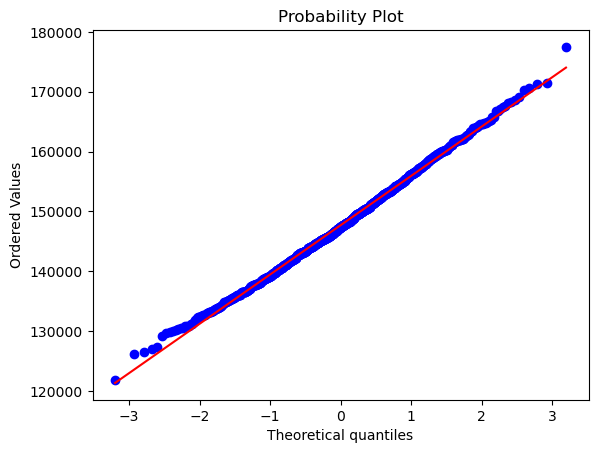

In [175]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

Видим, что есть расхождения с нормальным распределением. Поэтому полагаться на т-тест не стоит. Построим такой же график для зарплаты по всем отточным.

In [176]:
t = pd.Series(
    [values_2.sample(
        300,replace=True).mean() for _ in range(1000)])

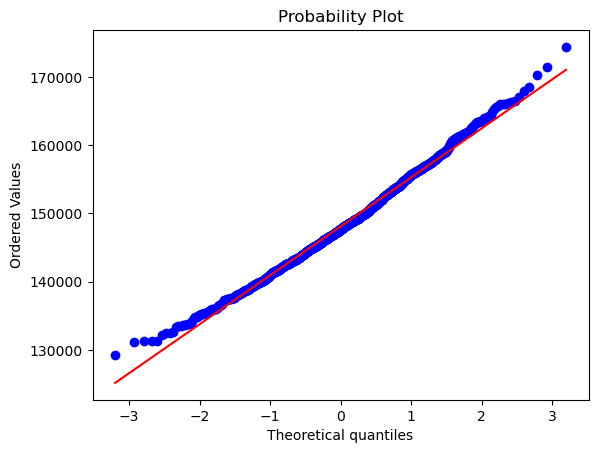

In [177]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

И тут тоже расхождения есть. Поэтому лучше ориентироваться на результаты теста Манна-Уитни. Он нам сказал, что в обоих случаях есть стат. значимость:
* средняя зп отточных клиентов значимо отличается от зп неотточных;
* средняя зп отточных с зп от 100 до 250 т.р. включительно значимо отличается от средней зп остальных отточных.

## Скоринг

Можно сразу же проверить как распределяются выборочные средние баллов скоринга. Возьмем нашу проблемную область - отточные клиенты с баллами от 820 до 930. И возьмем всех отточных. Сгенерируем выборочные средние на основе этих данных. Построим qq plot для обоих сгенерированных выборочных средних. 

Начнем со скоринга для всех отточных.

In [178]:
score_no_churn = data.query('churn==0')['score']
score_churn = data.query('churn==1')['score']

score_bad_churn = data.query('820<=score<=930 and churn==1')['score']
score_no_bad_churn = data[~data['score'].isin(score_bad_churn)]['score']

In [179]:
t = pd.Series(
    [score_churn.sample(
        300,replace=True).mean() for _ in range(1000)])

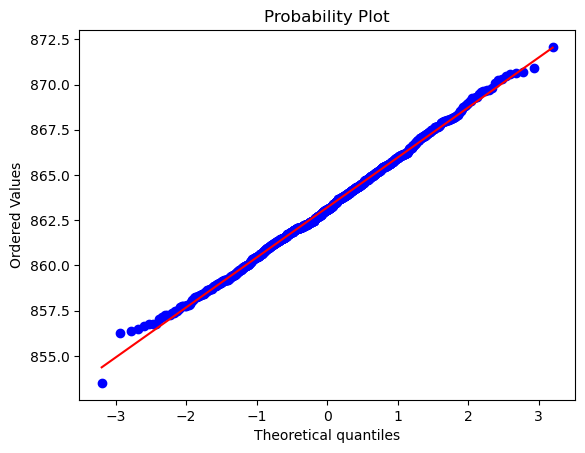

In [180]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

Видим небольшое расхождения с нормальным распределением. Значения по краям отскочили от диагонали.

Теперь проделаем тоже самое для отточных с баллами от 820 до 930.

In [181]:
t = pd.Series(
    [score_bad_churn.sample(
        300,replace=True).mean() for _ in range(1000)])

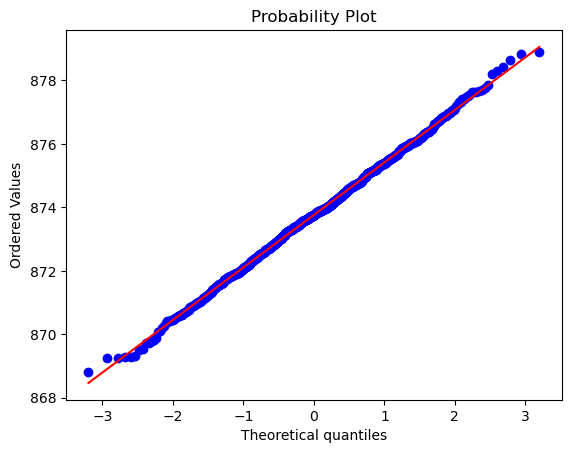

In [182]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

Тут уже распределение средних похуже. Остановимся и тут на тесте Манна-Уитни, так как у нас для всех выборки отточных искусственно сгенерированные выборочные оказались не совсем нормально распределены.

Посмотрим еще раз на наши средние.

In [183]:
mean_comparison ('score', 820, 930)

,показатель,значение
0,среднее неотточных,845.436451
1,среднее отточных,863.361936
2,среднее для проблемных отточных,873.800152
3,среднее по отточным за исключением проблемной группы,835.998008


Наиболее отточные клиенты имеют оценку скоринга от 820 до 930. Сравним среднее отточных и не отточных. А также среднее наиболее отточных клиентов со средним остальных отточных.

**Нулевая гипотеза: средняя оценка не отточных не отличается значимо от средней оценки отточных клиентов.\
Альтернативная гипотеза: есть значимая разница в средних оценках скоринга.**

In [184]:
mw(alpha, score_no_churn, score_churn)

p-value 6.072014214738013e-22
Отвергаем нулевую гипотезу: есть статистически значимые различия в средних значениях.


**Нулевая гипотеза: средняя оценка отточных с оценками от 820 до 930 включительно не отличается значимо от средней оценки остальных отточных клиентов.\
Альтернативная гипотеза: есть значимая разница в средних оценках скоринга.**

In [185]:
mw(alpha, score_bad_churn, score_no_bad_churn)

p-value 1.2956120600666964e-218
Отвергаем нулевую гипотезу: есть статистически значимые различия в средних значениях.


В обоих случаях есть стат.значимые различия. Значит можно допустить, что отточные клиенты имеют иную оценку кредитного скоринга. Тоже самое можем допустить и для отточных клиентов с баллами от 830 до 920.

## Возраст

Сравнивая средние мы увидели, что отточные и не отточные клиенты имеют схожий средний возраст. Узнаем найдет ли тест различия.

Сперва построим qq plot для обоих выборок. У возраста дисперсия должна быть поменьше, возможно подойдет и тест Стьюдента.

In [186]:
age_churn = data.query('churn==1')['age']
age_no_churn = data.query('churn==0')['age']

print(data.query('churn==1')['age'].mean())
data.query('churn==0')['age'].mean()

41.42959295929593


43.01628825271471

In [187]:
t = pd.Series(
    [age_churn.sample(
        300,replace=True).mean() for _ in range(1000)])

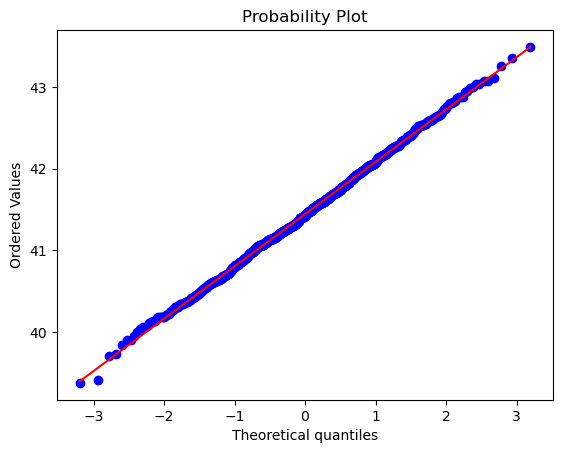

In [188]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

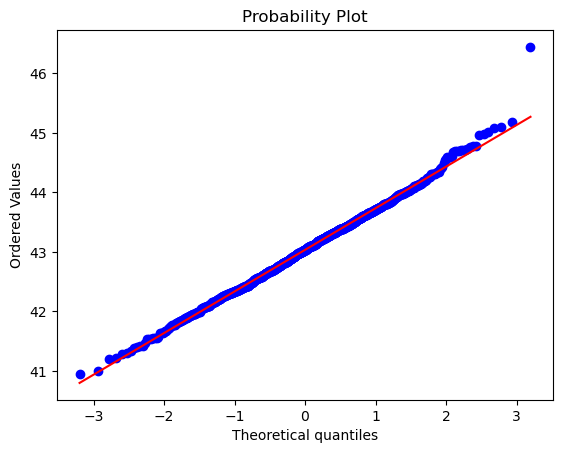

In [189]:
t = pd.Series(
    [age_no_churn.sample(
        300,replace=True).mean() for _ in range(1000)])

stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

Распределения имеют расхождения с нормальным. Снова используем критерий Манна-Уитни.

**Нулевая гипотеза: средний возраст отточных клиентов не отличается значимо от среднего возраста не отточных.\
Альтернативная гипотеза: есть значимая разница в среднем возрасте.**

У возраста у нас проверка одной гипотеза, поэтому уровень значимости тут не корректируем.

In [190]:
alpha=0.05
mw(alpha, age_no_churn, age_churn)

p-value 4.122295485981862e-06
Отвергаем нулевую гипотезу: есть статистически значимые различия в средних значениях.


Различия в 1,5 года оказались стат. значимыми для наших выборок. Будем исходить из того, что отточные клиенты имеют другой возраст, вероятно, более высокий, так как такие получились у нас средние.

## Выводы к разделу

* Во всех тестах мы использовали тест Манна-Уитни, так как в наших данных есть выбросы, что не позволяет выборочным средним быть распределенным нормально.
* Тест говорит о значимых различиях в зарплате у отточных и не отточных. А также у отточных с зп от 100 вкл. до 250 вкл. и остальных отточных. Можно заключит, что отточные клиенты имеют свой явный портрет, как и сильно отточные.
* Тест говорит о значимом различии средних оценок скоринга для отточных и нет. А также у сильно отточных (от 820 до 930 баллов вкл.) и остальных отточных. Значит оценка скоринга может говорить о вероятности оттока.
* Различия в среднем возрасте в 1,5 года у отточных и нет оказались стат. значимыми. Можно предположить, что возраст значимо влияет на вероятность оттока, если человек уже в категории отточных.

# Составление портрета и рекомендации для удержания клиентов

## Вспомним полезные выводы прошлых разделов

И так, нам есть из чего выбирать:

* Серьезно превышают среднее значение по датасету, как минимум в 1,6 раза, клиенты с 3,4,5 продуктами.
* Клиенты с 3 баллами собственности имеют долю оттока на 16% выше, чем в среднем. Клиенты с 4 баллами на 38% выше. Клиенты с еще большим кол-вом баллов минимум на 66% в зависимости от баллов.
* Доля отточных клиентов среди мужчин превышает среднее значение на 18%.
* Люди без кредитной карты примерно в 1.42 раза чаще являются отточными.
* Люди с недавней значимой активностью примерно в 1.36 раза чаще, чем в среднем близки к уходу из банка.

* По признаку зарплаты проблемная область - клиенты с зп от 100 до 250 т.р.\
Их среднее значимо отличается от средней зп остальных отточных. Значит, клиенты попадающие в такую группу говорят нам о том, что на них надо обратить внимание и удержать их в банке.
 
* По признаку баланса проблемные области - клиенты с балансом от 1 млн.р. до 4,5 млн.р.\
Средний баланс среди отточных клиентов выше среднего для неотточных в 1.55 раза. Для клиентов с балансом от 1 до 4,5 млн.среднее в 2.25 раза больше, чем среднее по остальным отточным.\
Значит, отточные клиенты с балансом от 1 до 4,5 млн.р. - это признак, который хорошо характеризует людей, кто может уйти из банка.

* По признаку возраста проблемные области - клиенты до 35 вкл. и от 49 лет до 61 вкл.\
Проблемные категории по возрасту достаточно далеко находятся от среднего среди остальных отточных. Значит эти категории вполне можно использовать при создании портрета отточного клиента.
* По признаку баллов кредитного скоринга проблемная область - клиенты, у кого от 820 вкл. до 930 баллов вкл.\
Средний балл скоринга среди отточных клиентов выше неотточного среднего в 1.02 раза, а для отточных клиентов с баллом от 820 до 930 млн.среднее в 1.01 раза больше, чем по остальным отточным.\
Разница минимальная, но значимость различий есть. Можно считать, что это тоже важный признак, характерезующий отточных клиентов.

Наибольшая связь у столбца оттока/не оттока с баллами собственности.\
Также выше 0.1 связь с оценкой скоринга, полом, возрастом, количеством продуктов, наличием кредитной карты, последней активностью.

## Выбор наиболее отточных групп

### Сегменты связанные с кол-вом продуктов и баллами собственности

Сперва возьмем те показатели, которые коррелируют с оттоком и не оттоком.

**Возьмем клиентов мужского пола с 3,4,5 продуктами.**

In [191]:
prod_male = data_initial.query('gender=="М" and (products==3 or products==4 or products==5)')

In [192]:
print(f'Всего таких клиентов {prod_male.user_id.count()}.\
 Доля отточных среди них составляет {prod_male.churn.mean():.2%}.\
 Это в {(prod_male.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 747. Доля отточных среди них составляет 50.33%. Это в 2.7 раза больше, чем в среднем по данным.


Но мы можем еще глубже сегментировать с использованием возраста. Чтобы предложить клиентам что-то более точечно.
Например, возьмем клиентов в возрасте от 49 до 61. Мы увидим, что отток среди них даже больше половины. Но группа совсем маленькая.

In [193]:
prod_age_male = prod_male.query('49<=age<=61')

In [194]:
print(f'Всего таких клиентов {prod_age_male.user_id.count()}.\
 Доля отточных среди них составляет {prod_age_male.churn.mean():.2%}.\
 Это в {(prod_age_male.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 166. Доля отточных среди них составляет 60.24%. Это в 3.3 раза больше, чем в среднем по данным.


Если вязть людей до 35 лет, то мы получим отток даже поменьше, чем если не разделять по возрасту. 

In [195]:
prod_age_male_1 = prod_male.loc[(~prod_male['age'].isin(prod_age_male['age']))]
prod_age_male_1 = prod_age_male_1.query('age<35')

In [196]:
print(f'Всего таких клиентов {prod_age_male_1.user_id.count()}.\
 Доля отточных среди них составляет {prod_age_male_1.churn.mean():.2%}.\
 Это в {(prod_age_male_1.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 232. Доля отточных среди них составляет 48.71%. Это в 2.7 раза больше, чем в среднем по данным.


В итоге, не будем разбивать по возрасту и возьмем всех мужчин с 3,4 или 5 продуктами. 

**Теперь возьмем мужчин, у которых от 4 баллов собственности.**\
Отфильтруем датасет таким образом, чтобы туда не попали люди с 3,4 или 5 продуктами.

In [197]:
equity_male = data_initial.loc[(~data_initial['user_id'].isin(prod_male['user_id']))]

equity_male = equity_male.query('gender=="М" and equity>=4')

In [198]:
print(f'Всего таких клиентов {equity_male.user_id.count()}.\
 Доля отточных среди них составляет {equity_male.churn.mean():.2%}.\
 Это в {(equity_male.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 1491. Доля отточных среди них составляет 32.39%. Это в 1.8 раза больше, чем в среднем по данным.


Если мы попытаемся выделить группу людей до 35 лет, то большой разницы не увидим.

In [199]:
equity_male_1 = equity_male.query('age<=35')

In [200]:
print(f'Всего таких клиентов {equity_male_1.user_id.count()}.\
 Доля отточных среди них составляет {equity_male_1.churn.mean():.2%}.\
 Это в {(equity_male_1.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 585. Доля отточных среди них составляет 36.92%. Это в 2.0 раза больше, чем в среднем по данным.


Группа людей от 49 до 61 слишком маленькая. До 300.

In [201]:
equity_male_2 = equity_male.query('49<=age<=61')

In [202]:
print(f'Всего таких клиентов {equity_male_2.user_id.count()}.\
 Доля отточных среди них составляет {equity_male_2.churn.mean():.2%}.\
 Это в {(equity_male_2.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 284. Доля отточных среди них составляет 38.73%. Это в 2.1 раза больше, чем в среднем по данным.


Поэтому остановимся на всех мужчинах с 4 баллами и более.

### Сегменты на основе пола, скоринга, возраста, наличия кредитной карты, активности

**Теперь возьмем клиентов мужского пола и без кредитной карты.**\
Отфильтруем таким образом, чтобы не было совпадений с 'prod_male' и 'prod_male'.\
То есть мужской пол оставляем, но убираем тех, у кого 3,4 или 5 продуктов и от 4 баллов собственности.

In [203]:
def churn_portrait(value_1, value_2, indicator, gender):
    
    portrait = data_initial.loc[(~data_initial['products'].isin(prod_male['user_id']))&(
                                 ~data_initial['equity'].isin(equity_male['equity']))]

    portrait = portrait.loc[(portrait[indicator]>=value_1)&(portrait[indicator]<=value_2)]
    portrait = portrait[portrait['gender']==gender]
    print(f'Всего в группе {portrait.user_id.count()} человек.')
    print(f'Отток составляет {portrait.churn.mean():.2%}.')

In [204]:
churn_portrait(0, 0, 'credit_card', 'М')

Всего в группе 597 человек.
Отток составляет 18.26%.


Слишком маленькая доля оттока. Такие клиенты нам не подойдут.

**Теперь возьмем клиентов мужского пола и в возрасте до 35 лет и от 49 до 61 из тех, которых мы еще не задействовали.**

In [205]:
churn_portrait(49, 61, 'age', 'М')

Всего в группе 509 человек.
Отток составляет 20.24%.


Среди оставшихся людей от 49 до 61 отток меньше среднего. Значит, самых отточных среди них уже взяли. Если выбрать женский пол, то отточных и того меньше.

In [206]:
churn_portrait(0, 35, 'age', 'М')

Всего в группе 1160 человек.
Отток составляет 14.57%.


Среди оставшихся людей до 35 лет отток меньше среднего. Значит, самых отточных среди них уже тоже взяли. Если выбрать женский пол, то отточных и того меньше.

**Посмотрим на тех клиентов, у кого была недавно значимая активность.**

Конечно учтем тех, кого уже выбрали как сильно отточных.

In [207]:
age = churn_portrait(1, 1, 'last_activity', 'М')

Всего в группе 1518 человек.
Отток составляет 16.60%.


И тут видим, что не осталось клиентов, которые имеют отток выше среднего.

**Посмотрим на баллы скоринга.**

In [208]:
churn_portrait(820, 930, 'score', 'М')

Всего в группе 1463 человек.
Отток составляет 16.13%.


Если брать за основу разделение пол, возраст, скоринг, наличие кредитной карты и активности, то нет интересных сегментов.
Посмотрим на разделение, где за основу возьмем зарплату и баланс с добавлением других характеристик.

### Сегменты на основе зарплаты и баланса

**Посмотрим на зп.**

Посмотрим что будет, если выбрать сегмент, который имеет мужской пол и вообще не пересекается с уже выбранными сегментами и имеет диапазон зп от 100 до 250 т.р.

In [209]:
churn_portrait(100000, 250000, 'est_salary', 'М')

Всего в группе 1647 человек.
Отток составляет 13.72%.


Слишком мало. Выберем всех мужчин с зп все также от 100 до 250, мужским полом и возрастом от 49 до 61. Не будем ставить таких жестких критериев по пересечению.

In [210]:
portrait = data_initial.loc[(data_initial['est_salary']>=100000)&(data_initial['est_salary']<=250000)]
portrait = portrait[portrait['gender']=='М']
portrait = portrait.query('49<=age<=61')

print(f'Всего в группе {portrait.user_id.count()} человек.')
print(f'Отток составляет {portrait.churn.mean():.2%}.')

Всего в группе 447 человек.
Отток составляет 30.65%.


Сегмент не очень большой, и доли оттока маловата для такого размера. Посмотрим на те же параметры, только при возрасте до 35 лет.

In [211]:
portrait = data_initial.loc[(data_initial['est_salary']>=100000)&(data_initial['est_salary']<=250000)]
portrait = portrait[portrait['gender']=='М']

portrait = portrait.query('age<35')
print(f'Всего в группе {portrait.user_id.count()} человек.')
print(f'Отток составляет {portrait.churn.mean():.2%}.')

Всего в группе 702 человек.
Отток составляет 28.35%.


Получаем слишком маленький отток. Что будет, если убрать пол.

In [212]:
portrait = data_initial.loc[(data_initial['est_salary']>=100000)&(data_initial['est_salary']<=250000)]

portrait = portrait.query('age<35')
print(f'Всего в группе {portrait.user_id.count()} человек.')
print(f'Отток составляет {portrait.churn.mean():.2%}.')

Всего в группе 1170 человек.
Отток составляет 26.24%.


Получаем снова слишком маленький отток. 

**Посмотрим на баланс**

Исходя из баланса можно рассматривать даже несколько хороших сегментов.\
Первый - это мужчины и женщины в возрасте от 49 до 61 лет с балансом от 1 млн. рублей до 4,5 млн. рублей.

In [213]:
portrait = data_initial.loc[(data_initial['balance']>=1000000)&(data_initial['balance']<=4500000)]
portrait = portrait.query('49<=age<=61')

print(f'Всего в группе {portrait.user_id.count()} человек.')
print(f'Отток составляет {portrait.churn.mean():.2%}.')

Всего в группе 482 человек.
Отток составляет 45.44%.


Но если мы уберем возрастное ограничение и добавим мужской пол, то будет и больше отток и больше людей.

Второй - это это мужчины с балансом от 1 млн. рублей до 4,5 млн. рублей.

In [214]:
portrait = data_initial.loc[(data_initial['balance']>=1000000)&(data_initial['balance']<=4500000)]
portrait = portrait[portrait['gender']=='М']

print(f'Всего в группе {portrait.user_id.count()} человек.')
print(f'Отток составляет {portrait.churn.mean():.2%}.')

Всего в группе 914 человек.
Отток составляет 49.34%.


У этого сегмента большое пересечение с уже выбранными двумя сегмента по баллам собственности и по продуктам.\
Если вычесть пересечение, то сегмент усохнет до таких значений.

In [215]:
portrait = data_initial.loc[(~data_initial['products'].isin(prod_male['products']))&(
                                 ~data_initial['equity'].isin(equity_male['equity']))]

portrait = portrait.loc[(data_initial['balance']>=1000000)&(portrait['balance']<=4500000)]
portrait = portrait[portrait['gender']=='М']

print(f'Всего в группе {portrait.user_id.count()} человек.')
print(f'Отток составляет {portrait.churn.mean():.2%}.')

Всего в группе 150 человек.
Отток составляет 34.67%.


Третий  сегмент на основе баланса - это мужчины до 35 лет с балансом от 1 млн. рублей до 4,5 млн. рублей.

In [216]:
balance_age = data_initial.loc[(data_initial['balance']>=1000000)&(data_initial['balance']<=4500000)]
balance_age = balance_age.query('35<=age')
balance_age = balance_age[balance_age['gender']=='М']

print(f'Всего в группе {balance_age.user_id.count()} человек.')
print(f'Отток составляет {balance_age.churn.mean():.2%}.')

Всего в группе 735 человек.
Отток составляет 45.44%.


У этого сегмента значительно меньше пересечение с уже выбранными двумя сегмента по баллам собственности и по продуктам.
Если вычесть пересечение, то сегмент усохнет до таких значений.

In [217]:
portrait = data_initial.loc[(~data_initial['products'].isin(prod_male['products']))&(
                                 ~data_initial['equity'].isin(equity_male['equity']))]

portrait = portrait.loc[(portrait['balance']>=1000000)&(portrait['balance']<=4500000)]
portrait = portrait.query('35<=age')
portrait = portrait[portrait['gender']=='М']

print(f'Всего в группе {portrait.user_id.count()} человек.')
print(f'Отток составляет {portrait.churn.mean():.2%}.')

Всего в группе 126 человек.
Отток составляет 30.95%.


Так что третий сегмент нам подойдет. 

## Вывод к разделу и предложения по удержанию клиентов

Мы получили три сегмента с высоким оттоком:\
**1) Клиенты мужского пола с 3,4,5 продуктами.**

In [218]:
print(f'Всего таких клиентов {prod_male.user_id.count()}.\
 Доля отточных среди них составляет {prod_male.churn.mean():.2%}.\
 Это в {(prod_male.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 747. Доля отточных среди них составляет 50.33%. Это в 2.7 раза больше, чем в среднем по данным.


Эти люди активно используют банковские продукты, как минимум 3-мя уже пользуются и это только у нас. Вероятно и в других банках тоже что-то используют. Есть люди среднего возраста. 

1) Можно предложить что-то с привязкой к семье. 

* Например, если муж и жена используют наш банк, то сделать повышенный кэшбек или поднять ставку по вкладу. 
* Можно выпускать карты для членов семьи, которые привязаны к одному счету. Для них можно установить специальную градацию кэшбеков в зависимости от карт.
* Можно предложить продукты связанные со страхование здоровья для всех членов семьи и для детей, в особенности.
* Возможно, у нас есть партнеры/клиенты юр.лица среди медицинских клиник, можно с ними связаться и для клиентов и их семей организовать медицинские чек-апы на хороших условиях.
* Можно предлагать старахование в путешествиях для семьи.
* Можно выпускать дебетовые карты для детей, начиная, допустим, с 14 лет с привязкой к счету отца/матери.
* Активнее продвигать ипотечные программы по хорошим ставка, опирая не только на доход клиента, но и всей семьи.
Если видим, что семья в целом состоятельная, то можно предложить более приятные условия.

2) Если человек активно использует банковские продукты, то почти точно используют что-то связанное с накоплением средств и сохранением.
* Можно в зависимости от расходов по всем картам членов семьи предлагать повышенную ставку вкладу на сумму вклада, допустим, в пределах 10 млн.руб.
* Точно также можно предлагать интересные вклады в зависимости от расходов самого владельцы счета.
* Можно снижать комиссию за доверительное управление активами, брокерское обслуживание в банке при определенных расходах по картам или суммах инвестиций.

4) Кредиты, кредитные карты, ипотека.
* Можно предложить кредитную карту с большим беспроцентным периодом, если клиент тратит по карте больше определенной суммы в месяц. 
* Возможно, у них стоит вопрос покупки жилья или есть ипотека у нас/в другому банке. Тогда можно предлагать более интересные ставки по ипотеке в зависимости от объемов активов, объемов трат по картам нашего банка - привлечь их активность и их капитал в наш банк таким образом.

5) Им могут быть интересны путешествия, поэтому можно предложить накопление миль за покупки, страхование в путешествиях. Повышенный кэшбек за покупку авиабилетов, бронирование отелей.

**2) Клиенты мужского пола, у которых от 4 и более баллов собственности.**

In [219]:
print(f'Всего таких клиентов {equity_male.user_id.count()}.\
 Доля отточных среди них составляет {equity_male.churn.mean():.2%}.\
 Это в {(equity_male.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 1491. Доля отточных среди них составляет 32.39%. Это в 1.8 раза больше, чем в среднем по данным.


1) У этих клиентов есть какая-либо собственность. Возможно им интересны продукты по страхованию недвижимости, автомобиля, загородных домов.
* Можно выслать наши самые интересные текущие предложения.
* Возможно у нас как юр.лица обслуживаются мебельные магазины, можно с ними связаться и дать возможность клиентам покупать мебель в рассрочку или в кредит с пониженной ставкой.
* Можно дать возможность погашать страховые платежи кэшбеком напрямую -  мотивировать людей использовать наши карты.
* Можно при использовании нашего страхования недвижимости повышать ставку по вкладу, т.е. это будет как пакетное предложение для клиентов.

2) Также им можно предложить продукты для бизнеса, возможно, они предприниматели. 
* Им можно предложить низкую ставку за эквайринг при условии, что клиент будет держать в нашем банке определенную сумму средств как физ.лицо или как юр.лицо.  
* Или аналогично можно снизить стоимость обслуживания счета юр.лица.

**3) Мужчины до 35 лет включительно с балансом от 1 млн. рублей до 4,5 млн. рублей.**

In [220]:
print(f'Всего таких клиентов {balance_age.user_id.count()}.\
 Доля отточных среди них составляет {balance_age.churn.mean():.2%}.\
 Это в {(balance_age.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 735. Доля отточных среди них составляет 45.44%. Это в 2.5 раза больше, чем в среднем по данным.


Это молодые клиенты, но уже с капиталом. В связи с этим для них можно предлагать что-то связанное с накоплением средств или тратами по картам.

* Уже указанные варианты: увеличение процента по вкладам и счетам в зависимости от денег на счетах, увеличение кэшбека в зависимости от трат.
* Для молодых клиентов с достатком также может быть интересен вопрос ипотеки. Поэтому можно улучшить условия в зависимости от расходов по картам и активов на счетах в нашем банке.
* Этим людям могут быть интересны путешествия, поэтому можно предложить накопление миль за траты по картам. 

**Подведем также итог по количеству**

Всего людей в наших группах.

In [221]:
balance_age.user_id.count()+equity_male.user_id.count()+prod_male.user_id.count()

2973

Пересечений по людям.

In [222]:
balance_age.user_id.count() - portrait.user_id.count()

609

Количество людей за вычетом пересечений.

In [223]:
clean_number = balance_age.user_id.count()+equity_male.user_id.count()\
+prod_male.user_id.count()-balance_age.user_id.count()-portrait.user_id.count()
clean_number

2112

Количество отточных среди чистого числа (за вычетом пересечений).

In [224]:
churn_rate = equity_male.churn.mean()*equity_male.user_id.count() +\
prod_male.churn.mean()*prod_male.user_id.count()+\
portrait.user_id.count()*portrait.churn.mean()
churn_rate

898.0

In [225]:
print(f'От суммарного чистого количества людей в выбранных сегментах доля чистых отточных\
составила {churn_rate/clean_number:.2%}.')

От суммарного чистого количества людей в выбранных сегментах доля чистых отточныхсоставила 42.52%.


# Итоговые выводы по проекту

**1) Взаимосвязь с оттоком.**

Сильнее всех связаны с оттоком баллы собственности, последняя активность, количество продуктов, оценка скоринга, пол, наличие кредитной карты. При этом особенно сильно связь есть с первыми тремя в списке.\
Серьезно превышают среднее значение по датасету, как минимум в 1,6 раза, клиенты с 3,4,5 продуктами.
Клиенты с 3 баллами собственности имеют долю оттока на 16% выше, чем в среднем. Клиенты с 4 баллами на 38% выше. Клиенты с еще большим кол-вом баллов минимум на 66% в зависимости от баллов.\
Поэтому, не удивительно, что самые отточные сегменты были сформированы именно за счет баллов собственности и количества продуктов.\
При этом мы добавили и мужской пол для более четкого понимания групп. Ведь отточных клиентов среди мужчин превышает среднее значение на 18%.\
Последняя активность хоть и коррелирует сильно с оттоком, но мы не знаем, что это за активность для предложения каких-то вариантов клиенту. Это может быть даже активность в связи с выводом денег. Поэтому нам не сконцентрироваться на этом признаке.

**2) Сегменты с сильным оттоком и предложения для клиентов.**

Мы получили два сегмента с высоким оттоком:\
-----**Клиенты мужского пола с 3,4,5 продуктами.**

In [226]:
print(f'Всего таких клиентов {prod_male.user_id.count()}.\
 Доля отточных среди них составляет {prod_male.churn.mean():.2%}.\
 Это в {(prod_male.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 747. Доля отточных среди них составляет 50.33%. Это в 2.7 раза больше, чем в среднем по данным.


Эти люди активно используют банковские продукты, как минимум 3-мя уже пользуются и это только у нас. Вероятно и в других банках тоже что-то используют. Есть люди среднего возраста. 

1) Можно предложить что-то с привязкой к семье. 

* Например, если муж и жена используют наш банк, то сделать повышенный кэшбек или поднять ставку по вкладу. 
* Можно выпускать карты для членов семьи, которые привязаны к одному счету. Для них можно установить специальную градацию кэшбеков в зависимости от карт.
* Можно предложить продукты связанные со страхование здоровья для всех членов семьи и для детей, в особенности.
* Возможно, у нас есть партнеры/клиенты юр.лица среди медицинских клиник, можно с ними связаться и для клиентов и их семей организовать медицинские чек-апы на хороших условиях.
* Можно предлагать старахование в путешествиях для семьи.
* Можно выпускать дебетовые карты для детей, начиная, допустим, с 14 лет с привязкой к счету отца/матери.
* Активнее продвигать ипотечные программы по хорошим ставкам, опираясь не только на доход клиента, но и всей семьи.
Если видим, что семья в целом состоятельная, то можно предложить более приятные условия.

2) Если человек активно использует банковские продукты, то почти точно используют что-то связанное с накоплением средств и сохранением.
* Можно в зависимости от расходов по всем картам членов семьи предлагать повышенную ставку вкладу на сумму вклада, допустим, в пределах 10 млн.руб.
* Точно также можно предлагать интересные вклады в зависимости от расходов самого владельцы счета.
* Можно снижать комиссию за доверительное управление активами, брокерское обслуживание в банке при определенных расходах по картам или суммах инвестиций.

4) Кредиты, кредитные карты, ипотека.
* Можно предложить кредитную карту с большим беспроцентным периодом, если клиент тратит по карте больше определенной суммы в месяц. 
* Возможно, у них стоит вопрос покупки жилья или есть ипотека у нас/в другому банке. Тогда можно предлагать более интересные ставки по ипотеке в зависимости от объемов активов, объемов трат по картам нашего банка - привлечь их активность и их капитал в наш банк таким образом.

5) Им могут быть интересны путешествия, поэтому можно предложить накопление миль за покупки, страхование в путешествиях. Повышенный кэшбек за покупку авиабилетов, бронирование отелей.

**-----Клиенты мужского пола, у которых от 4 и более баллов собственности.**

In [227]:
print(f'Всего таких клиентов {equity_male.user_id.count()}.\
 Доля отточных среди них составляет {equity_male.churn.mean():.2%}.\
 Это в {(equity_male.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 1491. Доля отточных среди них составляет 32.39%. Это в 1.8 раза больше, чем в среднем по данным.


1) У этих клиентов есть какая-либо собственность. Возможно им интересны продукты по страхованию недвижимости, автомобиля, загородных домов.
* Можно выслать наши самые интересные текущие предложения.
* Возможно у нас как юр.лица обслуживаются мебельные магазины, можно с ними связаться и дать возможность клиентам покупать мебель в рассрочку или в кредит с пониженной ставкой.
* Можно дать возможность погашать страховые платежи кэшбеком напрямую -  мотивировать людей использовать наши карты.
* Можно при использовании нашего страхования недвижимости повышать ставку по вкладу, т.е. это будет как пакетное предложение для клиентов.

2) Также им можно предложить продукты для бизнеса, возможно, они предприниматели. 
* Им можно предложить низкую ставку за эквайринг при условии, что клиент будет держать в нашем банке определенную сумму средств как физ.лицо или как юр.лицо.  
* Или аналогично можно снизить стоимость обслуживания счета юр.лица.

**-----Мужчины до 35 лет включительно с балансом от 1 млн. рублей до 4,5 млн. рублей.**

In [228]:
print(f'Всего таких клиентов {balance_age.user_id.count()}.\
 Доля отточных среди них составляет {balance_age.churn.mean():.2%}.\
 Это в {(balance_age.churn.mean()/data.churn.mean()):.2} раза больше, чем в среднем по данным.')

Всего таких клиентов 735. Доля отточных среди них составляет 45.44%. Это в 2.5 раза больше, чем в среднем по данным.


Это молодые клиенты, но уже с капиталом. В связи с этим для них можно предлагать что-то связанное с накоплением средств или тратами по картам.

* Уже указанные варианты: увеличение процента по вкладам и счетам в зависимости от денег на счетах, увеличение кэшбека в зависимости от трат.
* Для молодых клиентов с достатком также может быть интересен вопрос ипотеки. Поэтому можно улучшить условия в зависимости от расходов по картам и активов на счетах в нашем банке.
* Этим людям могут быть интересны путешествия, поэтому можно предложить накопление миль за траты по картам. 

**3) Проверка гипотез.**

* По признаку зарплаты проблемная область - клиенты с зп от 100 до 250 т.р.
Их среднее значимо отличается от средней зп остальных отточных. 
 
* По признаку баланса проблемные области - клиенты с балансом от 1 млн.р. до 4,5 млн.р.
Средний баланс среди отточных клиентов выше среднего для неотточных в 1.55 раза. Для клиентов с балансом от 1 до 4,5 млн.среднее в 2.25 раза больше, чем среднее по остальным отточным.
Значит, отточные клиенты с балансом от 1 до 4,5 млн.р. - это признак, который хорошо характеризует людей, кто может уйти из банка.

Зарплата и баланс не сильно коррелируют с оттоком. Значит это не является причиной того, что люди хотят уйти, но может являться характериской уходящих клиентов. Это нам говорит, кто наш отточный клиент. Поможет подобрать более подходящие для него продукты.\
В целом, видим, что это люди с достатком выше среднего. Могут интересоваться путешествиями, инвестициями, сохранением сбережений, имеют собственность.

* По признаку возраста проблемные области - клиенты до 35 вкл. и от 49 лет до 61 вкл.
Средний возраст наиболее отточных людей достаточно далеко находится от среднего среди остальных отточных. Значит эти категории вполне можно использовать при создании портрета отточного клиента.
* По признаку баллов кредитного скоринга проблемная область - клиенты, у кого от 820 вкл. до 930 баллов вкл.
Средний балл скоринга среди отточных клиентов выше неотточного среднего в 1.02 раза, а для отточных клиентов с баллом от 820 до 930 млн.среднее в 1.01 раза больше, чем по остальным отточным.\
Разница минимальная, но значимость различий есть. Можно считать, что это тоже важный признак, характерезующий отточных клиентов.

Возрастом мы пробовали воспользоваться при построении портрета, но этот способ сильно уменьшал выборку клиентов, поэтому оказался не оптимальным. Но мы всегда держим в уме, что среди отточных много людей молодых и среднего возраста. Исходя из этого делали рекомендации.

Баллы скоринга имеют помимо значимости различий еще и корреляцию. Но интерпретировать показатель тяжело, поэтому на основе него делили группы уже после более "говорящих" показателей. В итоге, не сформировались группы с большим оттоком.